<h1>Sommaire<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-des-bibliothèques" data-toc-modified-id="Import-des-bibliothèques-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import des bibliothèques</a></span></li><li><span><a href="#Approche-non-supervisée" data-toc-modified-id="Approche-non-supervisée-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Approche non-supervisée</a></span><ul class="toc-item"><li><span><a href="#LatentDirichletAllocation" data-toc-modified-id="LatentDirichletAllocation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LatentDirichletAllocation</a></span></li><li><span><a href="#NonNegativeMatrixFactorisation" data-toc-modified-id="NonNegativeMatrixFactorisation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>NonNegativeMatrixFactorisation</a></span></li></ul></li><li><span><a href="#Approche-supervisée" data-toc-modified-id="Approche-supervisée-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Approche supervisée</a></span><ul class="toc-item"><li><span><a href="#Analyse-de-la-taille-des-échantillons." data-toc-modified-id="Analyse-de-la-taille-des-échantillons.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Analyse de la taille des échantillons.</a></span></li><li><span><a href="#Séparation-des-données-et-préparation-des-modèles." data-toc-modified-id="Séparation-des-données-et-préparation-des-modèles.-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Séparation des données et préparation des modèles.</a></span></li><li><span><a href="#Modèles." data-toc-modified-id="Modèles.-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Modèles.</a></span><ul class="toc-item"><li><span><a href="#Dummy-Classifier" data-toc-modified-id="Dummy-Classifier-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Dummy Classifier</a></span></li><li><span><a href="#Naive-Base" data-toc-modified-id="Naive-Base-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Naive Base</a></span></li><li><span><a href="#SGD" data-toc-modified-id="SGD-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>SGD</a></span></li><li><span><a href="#Perceptron" data-toc-modified-id="Perceptron-3.3.4"><span class="toc-item-num">3.3.4&nbsp;&nbsp;</span>Perceptron</a></span></li><li><span><a href="#PassiveAgressive" data-toc-modified-id="PassiveAgressive-3.3.5"><span class="toc-item-num">3.3.5&nbsp;&nbsp;</span>PassiveAgressive</a></span></li></ul></li></ul></li><li><span><a href="#Modèle-retenu" data-toc-modified-id="Modèle-retenu-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Modèle retenu</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#export-du-modèle-final" data-toc-modified-id="export-du-modèle-final-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>export du modèle final</a></span></li></ul></li></ul></li></ul></div>

# Notebook de test 

## Import des bibliothèques

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer,CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD,LatentDirichletAllocation,NMF
from sklearn.cluster import DBSCAN,AgglomerativeClustering,SpectralClustering, AffinityPropagation
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder,StandardScaler,MultiLabelBinarizer
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.linear_model import PassiveAggressiveClassifier,Perceptron, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.utils import resample
from joblib import Parallel, delayed,dump
from sklearn.metrics import accuracy_score,make_scorer, classification_report,hamming_loss,jaccard_score,recall_score,precision_score,f1_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier,MultiOutputMixin
from sklearn.dummy import DummyClassifier
import time
from sklearn import set_config
set_config(display='diagram')

In [2]:
query_df=pd.read_csv("exported_query_df.csv",index_col='Id')
corpus_by_tag_df=pd.read_csv("corpus_by_tag.csv")

In [3]:
corpus_by_tag_df.index=corpus_by_tag_df['Unnamed: 0']
corpus_by_tag_df.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
query_df.columns

Index(['CreationDate', 'Body', 'Title', 'Body_text', 'Tag_list0', 'Tag_list1',
       'Tag_list2', 'Tag_list3', 'Tag_list4', 'Body_length',
       'Body_words_count', 'Body_words_tags_present', 'Title_length',
       'Title_words_count', 'Title_words_tags_present'],
      dtype='object')

On regarde les tags présents dans le jeu de données.

In [6]:
all_tag=[]
for i in query_df.columns:
    if 'Tag_l' in i :
        all_tag.extend(query_df[i].unique())
all_tag=set(all_tag)

In [10]:
query_df[[i for i in query_df.columns if 'Tag_l' in i]].count()

Tag_list0    99377
Tag_list1    91744
Tag_list2    67046
Tag_list3    36833
Tag_list4    15013
dtype: int64

In [12]:
corpus_by_tag_df.index

Index(['python', 'javascript', 'java', 'android', 'ios', 'c#', 'swift', 'html',
       'css', 'php',
       ...
       'opencv', 'machine-learning', 'ios7', 'amazon-s3', 'ios8',
       'uitableview', 'java-stream', 'android-layout', 'rust', 'csv'],
      dtype='object', name='Unnamed: 0', length=115)

In [13]:
keys_to_keep=list(corpus_by_tag_df.index)

In [14]:
len(keys_to_keep)

115

On modifie la fonction hamming_loss pour l'adapter à notre problème

In [15]:
hamming_score=make_scorer(lambda ytrue,ypred : 1- (len(keys_to_keep)/10.)*hamming_loss(ytrue,ypred),greater_is_better=True)

In [16]:
def modified_hamm_loss(ytrue,ypred):
    return (len(keys_to_keep)/10.)*hamming_loss(ytrue,ypred)

On supprime les tags avec une faible occurence puis on remplace quelques tags

In [22]:
map_dict={i:np.nan for i in all_tag-set(corpus_by_tag_df.index)}
for i in query_df.columns:
    if 'Tag_l' in i :
        print(i)
        query_df[i]=query_df[i].replace(map_dict)
        query_df[i]=query_df[i].replace('c++11','c++')
        query_df[i]=query_df[i].replace('ios7','ios')
        query_df[i]=query_df[i].replace('ios8','ios')
        query_df[i]=query_df[i].replace('.net-core','.net')

Tag_list0
Tag_list1
Tag_list2
Tag_list3
Tag_list4


On s'assure que toute les entrées comporte des tags

In [24]:
query_df=query_df.loc[query_df[[i for i in query_df.columns if 'Tag_l' in i]].dropna(axis=0,how='all').index]

In [25]:
tags_frequency= pd.Series(0,index={k  for i in ['Tag_list'+str(j) for j in np.arange(5) ] for k in query_df[i].unique() if k is not np.nan})
temp=pd.DataFrame()
for i in['Tag_list'+str(j) for j in np.arange(5) ]:
    temp[i]=query_df[i].value_counts().reindex(tags_frequency.keys())
tags_frequency=temp.fillna(0).transpose().apply(sum).sort_values(ascending=False)
del temp

In [26]:
for i in tags_frequency[tags_frequency>=350].keys():
    print(i,tags_frequency[tags_frequency>=350][i])

python 14292.0
javascript 11119.0
java 8657.0
android 8170.0
ios 6707.0
c# 5188.0
swift 4845.0
html 3911.0
c++ 3606.0
css 3597.0
php 3225.0
node.js 3200.0
angular 3158.0
laravel 2736.0
reactjs 2699.0
xcode 2679.0
angularjs 2458.0
jquery 2380.0
git 2260.0
pandas 2126.0
visual-studio 2082.0
typescript 2045.0
r 2043.0
.net 1788.0
json 1637.0
ruby-on-rails 1628.0
arrays 1582.0
docker 1577.0
twitter-bootstrap 1479.0
objective-c 1440.0
android-studio 1431.0
sql 1387.0
asp.net-mvc 1375.0
spring 1323.0
mysql 1311.0
django 1296.0
linux 1229.0
go 1130.0
string 1125.0
bash 1118.0
sql-server 1106.0
c 1041.0
asp.net-core 1031.0
amazon-web-services 1026.0
windows 1021.0
postgresql 1015.0
macos 1006.0
numpy 1005.0
flutter 935.0
react-native 932.0
asp.net 908.0
ruby 898.0
mongodb 875.0
dataframe 865.0
apache-spark 817.0
intellij-idea 813.0
gradle 806.0
github 779.0
scala 757.0
regex 754.0
kotlin 753.0
firebase 747.0
iphone 747.0
unit-testing 741.0
matplotlib 740.0
spring-boot 731.0
ubuntu 731.0
google

In [27]:
tags_frequency[tags_frequency>=400].shape

(98,)

In [28]:
map_dict={i:np.nan for i in all_tag-set(tags_frequency[tags_frequency>=350].index)}
for i in query_df.columns:
    if 'Tag_l' in i :
        print(i)
        query_df[i]=query_df[i].replace(map_dict)

Tag_list0
Tag_list1
Tag_list2
Tag_list3
Tag_list4


In [29]:
query_df=query_df.loc[query_df[[i for i in query_df.columns if 'Tag_l' in i]].dropna(axis=0,how='all').index]

In [30]:
query_df.Title_words_tags_present.describe()

count    97293.000000
mean         0.919151
std          0.809510
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: Title_words_tags_present, dtype: float64

## Approche non-supervisée

### LatentDirichletAllocation

In [31]:
lda=LatentDirichletAllocation(n_components=len(tags_frequency[tags_frequency>=350].index))

In [32]:
custom_stop_word_list=list(TfidfVectorizer(stop_words='english').get_stop_words())
custom_stop_word_list.extend([chr(i) for i in np.arange(97,99)])
custom_stop_word_list.extend([chr(i) for i in np.arange(101,114)])
custom_stop_word_list.extend([chr(i) for i in np.arange(115,180)])
custom_stop_word_list.extend([str(i) for i in np.arange(0,180)])
custom_stop_word_list.extend([str(i) for i in [10,100,1000,10000,100000,1000000]])

In [33]:
tfidf=TfidfVectorizer(ngram_range=(1,2),stop_words=custom_stop_word_list,
                      max_df=1/113,
                      min_df=1/(113*10),
                      sublinear_tf=False)
tfidf_titre=TfidfVectorizer(binary=True,use_idf=False,norm=False,vocabulary=tags_frequency.index,stop_words=custom_stop_word_list,sublinear_tf=False)

In [34]:
tf_df=tfidf.fit_transform(query_df.Body_text.apply(str))

On va un peu tricher et rajouter les tags au vocabulaire. On met la formule ici à titre d'exemple mais on la recalculera après séparation des données d'entrainement et de test.

In [35]:
new_vocab=tfidf.vocabulary_.keys()|tags_frequency.index

In [36]:
len(new_vocab)

6054

In [37]:
lda_df=lda.fit_transform(tf_df)

In [38]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 40
display_topics(lda, tfidf.get_feature_names(), no_top_words)


Topic 0:
grep pool cs datepicker startup picker cut processes scheme older customize connections somebody automatic static class aka startup cs mocha dispose somebody help del pk usable older version possible set ea reactive error object touched tedious need access creates new inherit want start ba website using stopping intend creates kill
Topic 1:
param category tasks writeline console writeline categories navigator pos todo eval rate version number developers yum fairly way know task task interactive standard library like run fairly new developers google create instance https developers class program json parse works like automated ce utilize params completes google com does happen using using completed professional static void new swift worry
Topic 2:
pdf dictionary dict age company student drive directories getter urls setter cost http example dictionaries pdf file example com bad practice files like overview recursively copies tried looking type value existence simulate visualstu

On peut voir que certaine propositions sont intéressantes mais que parfois elle ne sont pas exploitable notamment dans le topic 4 ou l'on retrouve des balises html

### NonNegativeMatrixFactorisation

In [39]:
nmf =NMF(n_components=len(tags_frequency[tags_frequency>=350].index),random_state=2)

In [40]:
nmf_df=nmf.fit_transform(tf_df)

In [41]:
display_topics(nmf, tfidf.get_feature_names(), no_top_words)


Topic 0:
condition break foo bar num queue shared limit pointer threads tasks differences usage ptr lock dispatch baz programming wait points equal book break case foo foo lists compare like know int int math operations deprecated keyword sense cpu bar foo logic declare comments comment moment statements
Topic 1:
android layout layout width layout height wrap content match parent parent android dp content android android id height wrap width match dp android android support textview linearlayout width wrap height match true android edittext support design android text design widget support widget android background gravity toolbar imageview textview android vertical relativelayout drawable schemas android height dp android orientation orientation width dp http schemas layout gravity gravity center android com
Topic 2:
li ul li li li ul nav li href li class ul li navbar ul class dropdown ul div toggle ng repeat repeat class nav tabs ngfor data toggle span class collapse list item contac

Nous avons encore ici le même problème que pour l'algorithme précédant. Nous décidons de ne pas conserver l'approche non supervisée.

## Approche supervisée

On va maintenant s'intéresser à des méthode supervisée pour classifier les textes. On va utiliser un nombre restreints de colonnes ainsi qu'une grille de recherche et des fonctions de préprocessing.

### Analyse de la taille des échantillons.

In [42]:
score=dict()
time_train=dict()
time_test=dict()
time_vocabulary=dict()
time_fit=dict()

non_word_column=['year']
words_columns=['Title','Body_text']
target_columns=['Tag_list0', 'Tag_list1',
       'Tag_list2', 'Tag_list3', 'Tag_list4']
std=StandardScaler()

nb_samples=list(np.arange(10,191,50))
nb_samples.extend(list(np.arange(200,2000,100)))
query_df['year']=pd.to_datetime(query_df.CreationDate).dt.year

train,test=train_test_split(query_df,test_size=0.2)


"\nfor i in query_df.columns:\n    if 'Tag_l' in i:\n        x=train[train[i].notna()].copy()\n        x['Tag']=x[i]\n        train=pd.concat([train,x],axis=0)"

In [43]:
train.shape

(77834, 16)

In [44]:
score=dict()
time_train=dict()
time_test=dict()
time_vocabulary=dict()
time_fit=dict()
score['precision']=dict()
score['recall']=dict()
score['f1 score']=dict()
score['jaccard']=dict()

hamm_loss=dict()
non_word_column=['year']
words_columns=['Title','Body_text']
target_columns=['Tag_list0', 'Tag_list1',
       'Tag_list2', 'Tag_list3', 'Tag_list4']
std=StandardScaler()


query_df['year']=pd.to_datetime(query_df.CreationDate).dt.year

train,test=train_test_split(query_df,test_size=0.2)
"""
for i in query_df.columns:
    if 'Tag_l' in i:
        x=train[train[i].notna()].copy()
        x['Tag']=x[i]
        train=pd.concat([train,x],axis=0)"""
for i in np.arange(1,30,3):
    sampled_train=pd.DataFrame()
    print('preparing train for %s sample\n' %i)
    startTime = time.time()
    sampled_train=train.copy()

#    for j in tags_frequency[tags_frequency>200].index:
#        x=train[train.Tag==j].copy()
#        x=resample(x,n_samples=600)
#        sampled_train=pd.concat([sampled_train,x],axis=0)
       
    
    X_train=sampled_train[non_word_column+words_columns]
    y_train=sampled_train[[i for i in sampled_train.columns if 'Tag_l' in i]]
    X_test=test[non_word_column+words_columns]
    y_test=test[[i for i in test.columns if 'Tag_l' in i]]
    mullab_enc=MultiLabelBinarizer()
    y_train=mullab_enc.fit_transform([set([j for j in i if j is not np.nan]) for i in y_train.values[:]])
    y_test=mullab_enc.transform([set([j for j in i if j is not np.nan]) for i in y_test.values[:]])
    
    tfidf_test=TfidfVectorizer(ngram_range=(1,2),stop_words=custom_stop_word_list,
                      max_df=5/113,
                      min_df=1/(113*float(i)),
                      sublinear_tf=False)
    
    tfidf_test.fit(X_train.Body_text)
    new_vocab=tfidf_test.vocabulary_.keys()|tags_frequency[tags_frequency>350].index
    tfidf2=TfidfVectorizer(ngram_range=(1,2),vocabulary=new_vocab,stop_words=custom_stop_word_list,sublinear_tf=True)
    
    
    word_proc=Pipeline([
        ('Tf-Idf',tfidf2),
    #    ('truncatedSVD_word',tsvd),
    ],verbose=True)
    
    title_proc=Pipeline([
        ('Tf-Idf',tfidf_titre),
    #    ('truncatedSVD',tsvd2),
    ],verbose=True)
    
    col_proc=ColumnTransformer([
    #    ('Scale',std,non_word_column),
        ('Word_processing',word_proc,'Body_text'),
        ('Title_processing',title_proc,'Title'),
    ],n_jobs=-3,verbose=True)
    
    print('Vocabulary constituted in %s'%(time.time() - startTime),'\n')
    
    executionTime = (time.time() - startTime)
    time_vocabulary[i]=executionTime
    startTime = time.time()
    prepared_train_df=col_proc.fit_transform(X_train)
    
    print('train preparing for %s sample\n' %i)
    
    executionTime = (time.time() - startTime)
    time_train[i]=executionTime
    
    print('Fitting time in seconds: ' + str(executionTime)+' for train %s samples' %i)
    
    startTime = time.time()
    prepared_test_df=col_proc.transform(X_test)
    executionTime = (time.time() - startTime)
    time_test[i]=executionTime
    
    print('Training time in seconds: ' + str(executionTime)+' for test %s samples\n' %i)
    
    nb = MultiOutputClassifier(MultinomialNB(),n_jobs=-1)

    startTime = time.time()
    nb.fit(prepared_train_df,y_train)
    executionTime = (time.time() - startTime)
    time_fit[i]=executionTime
    score['f1 score'][i]=f1_score(y_test,nb.predict(prepared_test_df),average='samples')
    score['precision'][i]=precision_score(y_test,nb.predict(prepared_test_df),average='samples')
    score['recall'][i]=recall_score(y_test,nb.predict(prepared_test_df),average='samples')
    score['jaccard'][i]=jaccard_score(y_test,nb.predict(prepared_test_df),average='samples')
    
    
    hamm_loss[i]=1-modified_hamm_loss(y_test,nb.predict(prepared_test_df))
    
    print("f1 score is %s for %s sample in %s\n"%(score['f1 score'][i],i,executionTime),50*"--"+"\n\n\n")

preparing train for 1 sample

Vocabulary constituted in 12.188159465789795 

train preparing for 1 sample

Fitting time in seconds: 10.01154637336731 for train 1 samples
Training time in seconds: 3.462477684020996 for test 1 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score is 0.47145201185234076 for 1 sample in 2.559044599533081
 ----------------------------------------------------------------------------------------------------



preparing train for 4 sample

Vocabulary constituted in 12.387584686279297 

train preparing for 4 sample

Fitting time in seconds: 8.652265548706055 for train 4 samples
Training time in seconds: 2.154578685760498 for test 4 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score is 0.5352546112605725 for 4 sample in 2.3264729976654053
 ----------------------------------------------------------------------------------------------------



preparing train for 7 sample

Vocabulary constituted in 12.905018329620361 

train preparing for 7 sample

Fitting time in seconds: 8.952162504196167 for train 7 samples
Training time in seconds: 2.1777565479278564 for test 7 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score is 0.5550143020953442 for 7 sample in 2.6150074005126953
 ----------------------------------------------------------------------------------------------------



preparing train for 10 sample

Vocabulary constituted in 12.662826299667358 

train preparing for 10 sample

Fitting time in seconds: 8.789989471435547 for train 10 samples
Training time in seconds: 2.2049560546875 for test 10 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score is 0.5608004753695695 for 10 sample in 2.5568127632141113
 ----------------------------------------------------------------------------------------------------



preparing train for 13 sample

Vocabulary constituted in 12.845826864242554 

train preparing for 13 sample

Fitting time in seconds: 9.003886938095093 for train 13 samples
Training time in seconds: 2.546175718307495 for test 13 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score is 0.5623033911460861 for 13 sample in 2.6914303302764893
 ----------------------------------------------------------------------------------------------------



preparing train for 16 sample

Vocabulary constituted in 12.287569522857666 

train preparing for 16 sample

Fitting time in seconds: 8.872409105300903 for train 16 samples
Training time in seconds: 2.2347683906555176 for test 16 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score is 0.5615168222496452 for 16 sample in 2.666248083114624
 ----------------------------------------------------------------------------------------------------



preparing train for 19 sample

Vocabulary constituted in 12.265431880950928 

train preparing for 19 sample

Fitting time in seconds: 9.316571235656738 for train 19 samples
Training time in seconds: 2.191380023956299 for test 19 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score is 0.5576550451621113 for 19 sample in 2.7292585372924805
 ----------------------------------------------------------------------------------------------------



preparing train for 22 sample

Vocabulary constituted in 12.35998821258545 

train preparing for 22 sample

Fitting time in seconds: 9.384909629821777 for train 22 samples
Training time in seconds: 2.2752766609191895 for test 22 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score is 0.5540344493142685 for 22 sample in 2.6467974185943604
 ----------------------------------------------------------------------------------------------------



preparing train for 25 sample

Vocabulary constituted in 12.433660507202148 

train preparing for 25 sample

Fitting time in seconds: 9.328949928283691 for train 25 samples
Training time in seconds: 2.6623992919921875 for test 25 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score is 0.5484492016996256 for 25 sample in 2.671998977661133
 ----------------------------------------------------------------------------------------------------



preparing train for 28 sample

Vocabulary constituted in 12.420416355133057 

train preparing for 28 sample

Fitting time in seconds: 9.764577388763428 for train 28 samples
Training time in seconds: 2.370051622390747 for test 28 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score is 0.542078011806672 for 28 sample in 2.7214772701263428
 ----------------------------------------------------------------------------------------------------





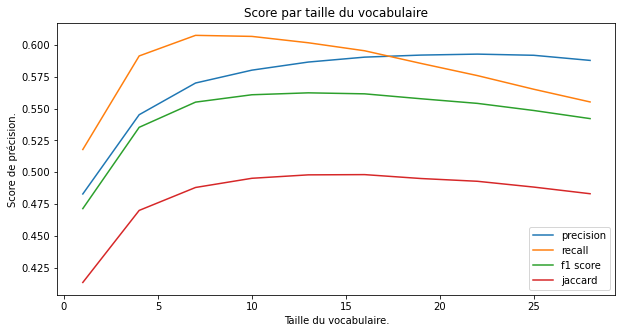

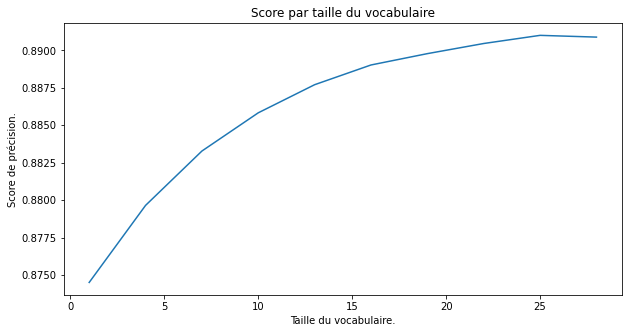

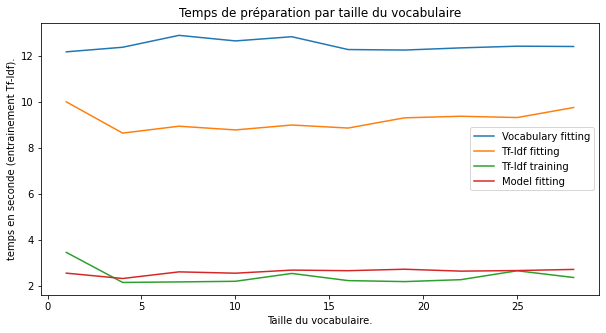

In [45]:
plt.figure(figsize=(10,5))
legend=[]
for i in score.keys():
    if 'hamm' not in i:
        sns.lineplot(x=score[i].keys(),y=score[i].values())
        legend.append(i)
plt.legend(legend)

plt.title("Score par taille du vocabulaire")
plt.ylabel('Score de précision.')
plt.xlabel('Taille du vocabulaire.')
plt.savefig(fname='terms_mindf_score_comparison.png',bbox_inches='tight')
plt.show()
plt.close()
plt.figure(figsize=(10,5))
sns.lineplot(x=hamm_loss.keys(),y=hamm_loss.values())
plt.title("Score par taille du vocabulaire")
plt.ylabel('Score de précision.')
plt.xlabel('Taille du vocabulaire.')
plt.savefig(fname='terms_mindf_hamm_loss_comparison.png',bbox_inches='tight')
plt.show()
plt.close()
plt.figure(figsize=(10,5))
sns.lineplot(x=time_vocabulary.keys(),y=time_vocabulary.values())
sns.lineplot(x=time_train.keys(),y=time_train.values())
sns.lineplot(x=time_test.keys(),y=time_test.values())
sns.lineplot(x=time_fit.keys(),y=time_fit.values())
plt.title("Temps de préparation par taille du vocabulaire")
plt.ylabel('temps en seconde (entrainement Tf-Idf).')
plt.xlabel('Taille du vocabulaire.')
plt.legend(['Vocabulary fitting','Tf-Idf fitting','Tf-Idf training','Model fitting'])
plt.savefig(fname='terms_mindf_training_times_comparison.png',bbox_inches='tight')
plt.show()
plt.close()

In [46]:
score=dict()
time_train=dict()
time_test=dict()
time_vocabulary=dict()
time_fit=dict()
score['precision']=dict()
score['recall']=dict()
score['f1 score']=dict()
score['jaccard']=dict()

hamm_loss=dict()
non_word_column=['year']
words_columns=['Title','Body_text']
target_columns=['Tag_list0', 'Tag_list1',
       'Tag_list2', 'Tag_list3', 'Tag_list4']
std=StandardScaler()


query_df['year']=pd.to_datetime(query_df.CreationDate).dt.year

train,test=train_test_split(query_df,test_size=0.2)
"""
for i in query_df.columns:
    if 'Tag_l' in i:
        x=train[train[i].notna()].copy()
        x['Tag']=x[i]
        train=pd.concat([train,x],axis=0)"""
for i in np.arange(1,11):
    sampled_train=pd.DataFrame()
    print('preparing train for %s sample\n' %i)
    startTime = time.time()
    sampled_train=train.copy()

#    for j in tags_frequency[tags_frequency>200].index:
#        x=train[train.Tag==j].copy()
#        x=resample(x,n_samples=600)
#        sampled_train=pd.concat([sampled_train,x],axis=0)
        
    X_train=sampled_train[non_word_column+words_columns]
    y_train=sampled_train[[i for i in sampled_train.columns if 'Tag_l' in i]]
    X_test=test[non_word_column+words_columns]
    y_test=test[[i for i in test.columns if 'Tag_l' in i]]
    mullab_enc=MultiLabelBinarizer()
    y_train=mullab_enc.fit_transform([set([j for j in i if j is not np.nan]) for i in y_train.values[:]])
    y_test=mullab_enc.transform([set([j for j in i if j is not np.nan]) for i in y_test.values[:]])
    
    tfidf_test=TfidfVectorizer(ngram_range=(1,2),stop_words=custom_stop_word_list,
                      max_df=i/113,
                      min_df=1/(113*15.),
                      sublinear_tf=False)
    
    tfidf_test.fit(X_train.Body_text)
    new_vocab=tfidf_test.vocabulary_.keys()|tags_frequency[tags_frequency>350].index
    tfidf2=TfidfVectorizer(ngram_range=(1,2),vocabulary=new_vocab,stop_words=custom_stop_word_list,max_df=16/54.,min_df=1/(54*8),sublinear_tf=True)
    
    
    word_proc=Pipeline([
        ('Tf-Idf',tfidf2),
    #    ('truncatedSVD_word',tsvd),
    ],verbose=True)
    
    title_proc=Pipeline([
        ('Tf-Idf',tfidf_titre),
    #    ('truncatedSVD',tsvd2),
    ],verbose=True)
    
    col_proc=ColumnTransformer([
    #    ('Scale',std,non_word_column),
        ('Word_processing',word_proc,'Body_text'),
        ('Title_processing',title_proc,'Title'),
    ],n_jobs=-3,verbose=True)
    
    print('Vocabulary constituted in %s'%(time.time() - startTime),'\n')
    
    executionTime = (time.time() - startTime)
    time_vocabulary[i]=executionTime
    startTime = time.time()
    prepared_train_df=col_proc.fit_transform(X_train)
    
    print('train preparing for %s sample\n' %i)
    
    executionTime = (time.time() - startTime)
    time_train[i]=executionTime
    
    print('Fitting time in seconds: ' + str(executionTime)+' for train %s samples' %i)
    
    startTime = time.time()
    prepared_test_df=col_proc.transform(X_test)
    executionTime = (time.time() - startTime)
    time_test[i]=executionTime
    
    print('Training time in seconds: ' + str(executionTime)+' for test %s samples\n' %i)
    
    nb = MultiOutputClassifier(MultinomialNB(),n_jobs=-1)

    startTime = time.time()
    nb.fit(prepared_train_df,y_train)
    executionTime = (time.time() - startTime)
    time_fit[i]=executionTime
    score['f1 score'][i]=f1_score(y_test,nb.predict(prepared_test_df),average='samples')
    score['precision'][i]=precision_score(y_test,nb.predict(prepared_test_df),average='samples')
    score['recall'][i]=recall_score(y_test,nb.predict(prepared_test_df),average='samples')
    score['jaccard'][i]=jaccard_score(y_test,nb.predict(prepared_test_df),average='samples')
    
    hamm_loss[i]=1-modified_hamm_loss(y_test,nb.predict(prepared_test_df))    
    print("f1 score is %s for %s sample in %s\n"%(score['f1 score'][i],i,executionTime),50*"--"+"\n\n\n")

preparing train for 1 sample

Vocabulary constituted in 12.63016152381897 

train preparing for 1 sample

Fitting time in seconds: 8.92348837852478 for train 1 samples
Training time in seconds: 2.4450719356536865 for test 1 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score is 0.5703935799598475 for 1 sample in 2.4349546432495117
 ----------------------------------------------------------------------------------------------------



preparing train for 2 sample

Vocabulary constituted in 12.625741720199585 

train preparing for 2 sample

Fitting time in seconds: 8.861949920654297 for train 2 samples
Training time in seconds: 2.167529344558716 for test 2 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score is 0.5658014887111964 for 2 sample in 2.4918882846832275
 ----------------------------------------------------------------------------------------------------



preparing train for 3 sample

Vocabulary constituted in 12.213279247283936 

train preparing for 3 sample

Fitting time in seconds: 9.203232049942017 for train 3 samples
Training time in seconds: 2.207206964492798 for test 3 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score is 0.5649385020652815 for 3 sample in 2.608720302581787
 ----------------------------------------------------------------------------------------------------



preparing train for 4 sample

Vocabulary constituted in 12.434020519256592 

train preparing for 4 sample

Fitting time in seconds: 9.268458843231201 for train 4 samples
Training time in seconds: 2.264752149581909 for test 4 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score is 0.5635364087751157 for 4 sample in 2.9585535526275635
 ----------------------------------------------------------------------------------------------------



preparing train for 5 sample

Vocabulary constituted in 13.79435658454895 

train preparing for 5 sample

Fitting time in seconds: 9.006606817245483 for train 5 samples
Training time in seconds: 2.264322519302368 for test 5 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score is 0.5640559382375508 for 5 sample in 3.040797233581543
 ----------------------------------------------------------------------------------------------------



preparing train for 6 sample

Vocabulary constituted in 12.869890213012695 

train preparing for 6 sample

Fitting time in seconds: 8.930164813995361 for train 6 samples
Training time in seconds: 2.520045042037964 for test 6 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score is 0.5620290473468952 for 6 sample in 2.761150360107422
 ----------------------------------------------------------------------------------------------------



preparing train for 7 sample

Vocabulary constituted in 12.999480962753296 

train preparing for 7 sample

Fitting time in seconds: 9.150156259536743 for train 7 samples
Training time in seconds: 2.575058937072754 for test 7 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score is 0.561547530245819 for 7 sample in 2.8416082859039307
 ----------------------------------------------------------------------------------------------------



preparing train for 8 sample

Vocabulary constituted in 15.924556255340576 

train preparing for 8 sample

Fitting time in seconds: 10.259464263916016 for train 8 samples
Training time in seconds: 2.775914430618286 for test 8 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score is 0.5611955896168858 for 8 sample in 3.376343011856079
 ----------------------------------------------------------------------------------------------------



preparing train for 9 sample

Vocabulary constituted in 13.84615421295166 

train preparing for 9 sample

Fitting time in seconds: 9.45749807357788 for train 9 samples
Training time in seconds: 2.579944610595703 for test 9 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score is 0.5603467630575909 for 9 sample in 3.000089645385742
 ----------------------------------------------------------------------------------------------------



preparing train for 10 sample

Vocabulary constituted in 12.837708711624146 

train preparing for 10 sample

Fitting time in seconds: 9.367220640182495 for train 10 samples
Training time in seconds: 2.325026035308838 for test 10 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score is 0.5586462067319256 for 10 sample in 2.7396531105041504
 ----------------------------------------------------------------------------------------------------





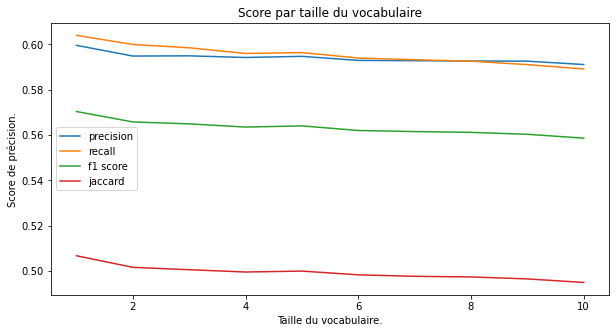

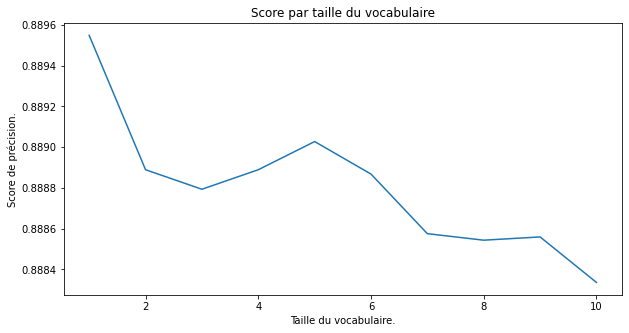

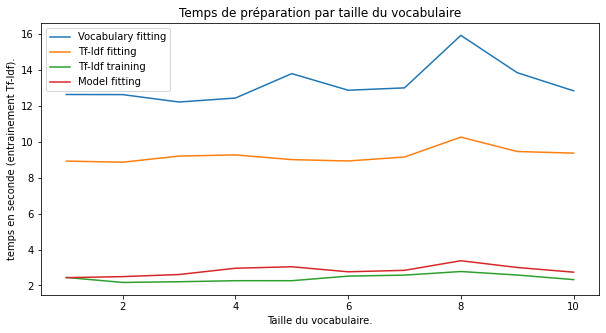

In [47]:
plt.figure(figsize=(10,5))
legend=[]
for i in score.keys():
    if 'hamm' not in i:
        sns.lineplot(x=score[i].keys(),y=score[i].values())
        legend.append(i)
plt.legend(legend)

plt.title("Score par taille du vocabulaire")
plt.ylabel('Score de précision.')
plt.xlabel('Taille du vocabulaire.')
plt.savefig(fname='terms_maxdf_score_comparison.png',bbox_inches='tight')
plt.show()
plt.close()
plt.figure(figsize=(10,5))
sns.lineplot(x=hamm_loss.keys(),y=hamm_loss.values())
plt.title("Score par taille du vocabulaire")
plt.ylabel('Score de précision.')
plt.xlabel('Taille du vocabulaire.')
plt.savefig(fname='terms_maxdf_hamm_loss_comparison.png',bbox_inches='tight')
plt.show()
plt.close()
plt.figure(figsize=(10,5))
sns.lineplot(x=time_vocabulary.keys(),y=time_vocabulary.values())
sns.lineplot(x=time_train.keys(),y=time_train.values())
sns.lineplot(x=time_test.keys(),y=time_test.values())
sns.lineplot(x=time_fit.keys(),y=time_fit.values())
plt.title("Temps de préparation par taille du vocabulaire")
plt.ylabel('temps en seconde (entrainement Tf-Idf).')
plt.xlabel('Taille du vocabulaire.')
plt.legend(['Vocabulary fitting','Tf-Idf fitting','Tf-Idf training','Model fitting'])
plt.savefig(fname='terms_maxdf_training_times_comparison.png',bbox_inches='tight')
plt.show()
plt.close()

In [48]:
score=dict()
time_train=dict()
time_test=dict()
time_vocabulary=dict()
time_fit=dict()
score['precision']=dict()
score['recall']=dict()
score['f1 score']=dict()
score['jaccard']=dict()

hamm_loss=dict()
non_word_column=['year']
words_columns=['Title','Body_text']
target_columns=['Tag_list0', 'Tag_list1',
       'Tag_list2', 'Tag_list3', 'Tag_list4']
std=StandardScaler()

nb_samples=list(np.arange(0,191,50))
nb_samples.extend(list(np.arange(200,1500,100)))
nb_samples.extend(np.arange(1500,2001,500))
query_df['year']=pd.to_datetime(query_df.CreationDate).dt.year

train,test=train_test_split(query_df,test_size=0.2)

for i in query_df.columns:
    if 'Tag_l' in i:
        x=train[train[i].notna()].copy()
        x['Tag']=x[i]
        train=pd.concat([train,x],axis=0)
for i in nb_samples:
    sampled_train=pd.DataFrame()
    print('preparing train for %s sample\n' %i)
    startTime = time.time()

    if i==0:
        sampled_train=train.copy()
    else:
        for j in tags_frequency[tags_frequency>350].index:
            x=train[train.Tag==j].copy()
            x=resample(x,n_samples=i)
            sampled_train=pd.concat([sampled_train,x],axis=0)
        
    X_train=sampled_train[non_word_column+words_columns]
    y_train=sampled_train[[i for i in sampled_train.columns if 'Tag_l' in i]]
    X_test=test[non_word_column+words_columns]
    y_test=test[[i for i in test.columns if 'Tag_l' in i]]
    mullab_enc=MultiLabelBinarizer()
    y_train=mullab_enc.fit_transform([set([j for j in i if j is not np.nan]) for i in y_train.values[:]])
    y_test=mullab_enc.transform([set([j for j in i if j is not np.nan]) for i in y_test.values[:]])
    

    
    tfidf.fit(X_train.Body_text)
    new_vocab=tfidf.vocabulary_.keys()|corpus_by_tag_df.index
    tfidf2=TfidfVectorizer(ngram_range=(1,2),vocabulary=new_vocab,stop_words=custom_stop_word_list,max_df=1/115.,min_df=1/(115*15),sublinear_tf=True)
    
    
    word_proc=Pipeline([
        ('Tf-Idf',tfidf2),
    #    ('truncatedSVD_word',tsvd),
    ],verbose=True)
    
    title_proc=Pipeline([
        ('Tf-Idf',tfidf_titre),
    #    ('truncatedSVD',tsvd2),
    ],verbose=True)
    
    col_proc=ColumnTransformer([
    #    ('Scale',std,non_word_column),
        ('Word_processing',word_proc,'Body_text'),
        ('Title_processing',title_proc,'Title'),
    ],n_jobs=-3,verbose=True)
    
    print('Vocabulary constituted in %s'%(time.time() - startTime),'\n')
    
    executionTime = (time.time() - startTime)
    time_vocabulary[i]=executionTime
    startTime = time.time()
    prepared_train_df=col_proc.fit_transform(X_train)
    
    print('train preparing for %s sample\n' %i)
    
    executionTime = (time.time() - startTime)
    time_train[i]=executionTime
    
    print('Fitting time in seconds: ' + str(executionTime)+' for train %s samples' %i)
    
    startTime = time.time()
    prepared_test_df=col_proc.transform(X_test)
    executionTime = (time.time() - startTime)
    time_test[i]=executionTime
    
    print('Training time in seconds: ' + str(executionTime)+' for test %s samples\n' %i)
    
    nb = MultiOutputClassifier(MultinomialNB(),n_jobs=-1)

    startTime = time.time()
    nb.fit(prepared_train_df,y_train)
    executionTime = (time.time() - startTime)
    time_fit[i]=executionTime
    score['f1 score'][i]=f1_score(y_test,nb.predict(prepared_test_df),average='samples')
    score['precision'][i]=precision_score(y_test,nb.predict(prepared_test_df),average='samples')
    score['recall'][i]=recall_score(y_test,nb.predict(prepared_test_df),average='samples')
    score['jaccard'][i]=jaccard_score(y_test,nb.predict(prepared_test_df),average='samples')
    
    hamm_loss[i]=1-modified_hamm_loss(y_test,nb.predict(prepared_test_df))        
    print("score is %s for %s sample in %s\n"%(score['f1 score'][i],i,executionTime),50*"--"+"\n\n\n")

preparing train for 0 sample

Vocabulary constituted in 49.2273108959198 

train preparing for 0 sample

Fitting time in seconds: 35.32743740081787 for train 0 samples
Training time in seconds: 2.1052310466766357 for test 0 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


score is 0.5475181755052252 for 0 sample in 5.6710734367370605
 ----------------------------------------------------------------------------------------------------



preparing train for 50 sample

Vocabulary constituted in 3.4930500984191895 

train preparing for 50 sample

Fitting time in seconds: 0.9832422733306885 for train 50 samples
Training time in seconds: 2.249621868133545 for test 50 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


score is 0.37160129927229985 for 50 sample in 1.72999906539917
 ----------------------------------------------------------------------------------------------------



preparing train for 100 sample

Vocabulary constituted in 4.260857582092285 

train preparing for 100 sample

Fitting time in seconds: 1.493035078048706 for train 100 samples
Training time in seconds: 2.5034890174865723 for test 100 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


score is 0.45330972651492724 for 100 sample in 0.6448502540588379
 ----------------------------------------------------------------------------------------------------



preparing train for 150 sample

Vocabulary constituted in 5.540663480758667 

train preparing for 150 sample

Fitting time in seconds: 2.200922727584839 for train 150 samples
Training time in seconds: 2.208185911178589 for test 150 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


score is 0.4906429784249816 for 150 sample in 0.6057252883911133
 ----------------------------------------------------------------------------------------------------



preparing train for 200 sample

Vocabulary constituted in 6.765420913696289 

train preparing for 200 sample

Fitting time in seconds: 2.6595497131347656 for train 200 samples
Training time in seconds: 2.1249327659606934 for test 200 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


score is 0.5068546484549362 for 200 sample in 0.6710777282714844
 ----------------------------------------------------------------------------------------------------



preparing train for 300 sample

Vocabulary constituted in 8.675255537033081 

train preparing for 300 sample

Fitting time in seconds: 3.9712295532226562 for train 300 samples
Training time in seconds: 2.1688389778137207 for test 300 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


score is 0.5214807060267954 for 300 sample in 0.7948329448699951
 ----------------------------------------------------------------------------------------------------



preparing train for 400 sample

Vocabulary constituted in 10.329754829406738 

train preparing for 400 sample

Fitting time in seconds: 5.271078586578369 for train 400 samples
Training time in seconds: 2.2241783142089844 for test 400 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


score is 0.5253235381710637 for 400 sample in 2.1813621520996094
 ----------------------------------------------------------------------------------------------------



preparing train for 500 sample

Vocabulary constituted in 12.889944314956665 

train preparing for 500 sample

Fitting time in seconds: 6.425654172897339 for train 500 samples
Training time in seconds: 2.423309564590454 for test 500 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


score is 0.5253345352194213 for 500 sample in 2.2674214839935303
 ----------------------------------------------------------------------------------------------------



preparing train for 600 sample

Vocabulary constituted in 15.693520784378052 

train preparing for 600 sample

Fitting time in seconds: 7.702341556549072 for train 600 samples
Training time in seconds: 2.1392831802368164 for test 600 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


score is 0.5266239915476773 for 600 sample in 2.2872536182403564
 ----------------------------------------------------------------------------------------------------



preparing train for 700 sample

Vocabulary constituted in 16.69371509552002 

train preparing for 700 sample

Fitting time in seconds: 8.884765863418579 for train 700 samples
Training time in seconds: 2.225275993347168 for test 700 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


score is 0.5282041402191462 for 700 sample in 2.6557564735412598
 ----------------------------------------------------------------------------------------------------



preparing train for 800 sample

Vocabulary constituted in 19.248725652694702 

train preparing for 800 sample

Fitting time in seconds: 11.18025803565979 for train 800 samples
Training time in seconds: 2.6968212127685547 for test 800 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


score is 0.5287617111349061 for 800 sample in 2.8182320594787598
 ----------------------------------------------------------------------------------------------------



preparing train for 900 sample

Vocabulary constituted in 21.13597798347473 

train preparing for 900 sample

Fitting time in seconds: 11.907137393951416 for train 900 samples
Training time in seconds: 2.541550636291504 for test 900 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


score is 0.5280362767232597 for 900 sample in 2.7493934631347656
 ----------------------------------------------------------------------------------------------------



preparing train for 1000 sample

Vocabulary constituted in 22.803189992904663 

train preparing for 1000 sample

Fitting time in seconds: 13.402199029922485 for train 1000 samples
Training time in seconds: 2.4130656719207764 for test 1000 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


score is 0.5262266663109462 for 1000 sample in 3.2098889350891113
 ----------------------------------------------------------------------------------------------------



preparing train for 1100 sample

Vocabulary constituted in 25.420485496520996 

train preparing for 1100 sample

Fitting time in seconds: 13.651857614517212 for train 1100 samples
Training time in seconds: 2.0204169750213623 for test 1100 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


score is 0.5274063375456048 for 1100 sample in 2.951058864593506
 ----------------------------------------------------------------------------------------------------



preparing train for 1200 sample

Vocabulary constituted in 26.3998544216156 

train preparing for 1200 sample

Fitting time in seconds: 15.211272716522217 for train 1200 samples
Training time in seconds: 2.171069622039795 for test 1200 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


score is 0.5250099507358359 for 1200 sample in 3.306849479675293
 ----------------------------------------------------------------------------------------------------



preparing train for 1300 sample

Vocabulary constituted in 28.802547693252563 

train preparing for 1300 sample

Fitting time in seconds: 16.151556730270386 for train 1300 samples
Training time in seconds: 2.355940818786621 for test 1300 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


score is 0.5263547973116809 for 1300 sample in 3.1247153282165527
 ----------------------------------------------------------------------------------------------------



preparing train for 1400 sample

Vocabulary constituted in 30.757875442504883 

train preparing for 1400 sample

Fitting time in seconds: 17.591267108917236 for train 1400 samples
Training time in seconds: 2.3962290287017822 for test 1400 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


score is 0.525706907250152 for 1400 sample in 3.333451986312866
 ----------------------------------------------------------------------------------------------------



preparing train for 1500 sample

Vocabulary constituted in 32.42973732948303 

train preparing for 1500 sample

Fitting time in seconds: 18.99489140510559 for train 1500 samples
Training time in seconds: 2.3650572299957275 for test 1500 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


score is 0.5239568181445975 for 1500 sample in 3.241873025894165
 ----------------------------------------------------------------------------------------------------



preparing train for 2000 sample

Vocabulary constituted in 41.925026416778564 

train preparing for 2000 sample

Fitting time in seconds: 25.24514412879944 for train 2000 samples
Training time in seconds: 2.0615580081939697 for test 2000 samples



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


score is 0.5247372882811496 for 2000 sample in 4.124007701873779
 ----------------------------------------------------------------------------------------------------





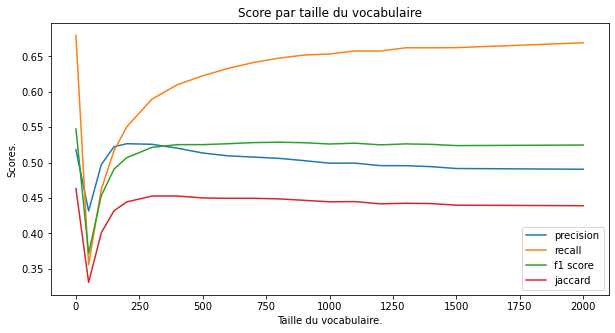

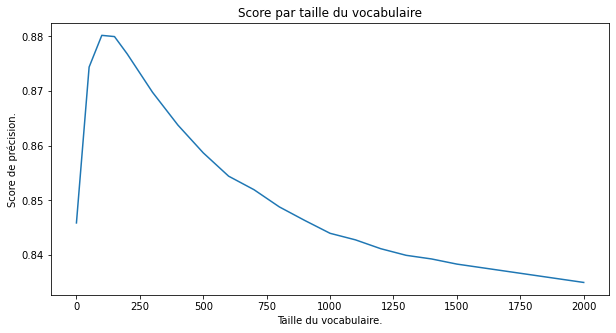

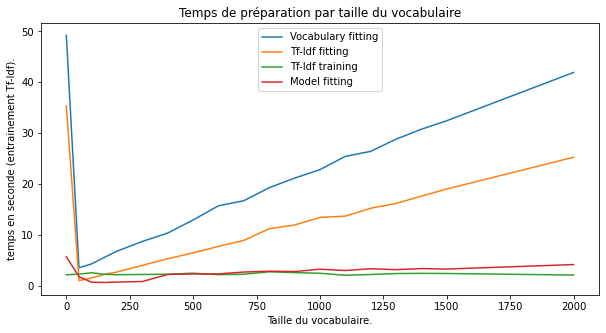

In [49]:
plt.figure(figsize=(10,5))
legend=[]
for i in score.keys():
    if 'hamm' not in i:
        sns.lineplot(x=score[i].keys(),y=score[i].values())
        legend.append(i)
plt.legend(legend)

plt.title("Score par taille du vocabulaire")
plt.ylabel('Scores.')
plt.xlabel('Taille du vocabulaire.')
plt.savefig(fname='samples_score_comparison.png',bbox_inches='tight')
plt.show()
plt.close()
plt.figure(figsize=(10,5))
sns.lineplot(x=hamm_loss.keys(),y=hamm_loss.values())
plt.title("Score par taille du vocabulaire")
plt.ylabel('Score de précision.')
plt.xlabel('Taille du vocabulaire.')
plt.savefig(fname='samples_hamm_loss_comparison.png',bbox_inches='tight')
plt.show()
plt.close()
plt.figure(figsize=(10,5))
sns.lineplot(x=time_vocabulary.keys(),y=time_vocabulary.values())
sns.lineplot(x=time_train.keys(),y=time_train.values())
sns.lineplot(x=time_test.keys(),y=time_test.values())
sns.lineplot(x=time_fit.keys(),y=time_fit.values())
plt.title("Temps de préparation par taille du vocabulaire")
plt.ylabel('temps en seconde (entrainement Tf-Idf).')
plt.xlabel('Taille du vocabulaire.')
plt.legend(['Vocabulary fitting','Tf-Idf fitting','Tf-Idf training','Model fitting'])
plt.savefig(fname='samples_training_times_comparison.png',bbox_inches='tight')
plt.show()
plt.close()

Dans la suite on utilisera les paramètre que l'on a trouvé.

### Séparation des données et préparation des modèles.

In [53]:
non_word_column=['year']
words_columns=['Title','Body_text']
target_columns=['Tag_list0', 'Tag_list1',
       'Tag_list2', 'Tag_list3', 'Tag_list4']

In [54]:
lab_enc=MultiLabelBinarizer()
train,test=train_test_split(query_df,test_size=0.2)
sampled_train=train.copy()


X_train=sampled_train[non_word_column+words_columns]
y_train=sampled_train[[i for i in train.columns if 'Tag_l' in i]]
X_test=test[non_word_column+words_columns]
y_test=test[[i for i in test.columns if 'Tag_l' in i]]
mullab_enc=MultiLabelBinarizer()
y_train=mullab_enc.fit_transform([set([j for j in i if j is not np.nan]) for i in y_train.values[:]])
y_test=mullab_enc.transform([set([j for j in i if j is not np.nan]) for i in y_test.values[:]])



['year']

On constitue maintenant notre vocabulaire auquel on ajoutera la liste des tags.

In [57]:
tfidf.fit(X_train.Body_text)

TfidfVectorizer(max_df=0.008849557522123894, min_df=0.0008849557522123894,
                ngram_range=(1, 2),
                stop_words=['back', 'throughout', 'herein', 'other', 'behind',
                            'becomes', 'eleven', 'describe', 'only',
                            'thereupon', 'inc', 'whatever', 'put', 'both',
                            'this', 'are', 'name', 'which', 'would', 'whither',
                            'also', 'thereafter', 'was', 'another', 'many',
                            'am', 'before', 'own', 'nothing', 'we', ...])

In [58]:
new_vocab=tfidf.vocabulary_.keys()|corpus_by_tag_df.index

In [59]:
std=StandardScaler(with_mean=False)
tsvd=TruncatedSVD(n_components=900, n_iter=20, random_state=2)
tsvd2=TruncatedSVD(n_components=180, n_iter=25, random_state=2)
new_vocab=tfidf.vocabulary_.keys()|corpus_by_tag_df.index
tfidf2=TfidfVectorizer(ngram_range=(1,2),vocabulary=new_vocab,stop_words=custom_stop_word_list,max_df=16/54.,min_df=1/(54*8),sublinear_tf=True)
word_proc=Pipeline([
    ('Tf-Idf',tfidf2),
#    ('truncatedSVD_word',tsvd),
],verbose=True)
title_proc=Pipeline([
    ('Tf-Idf',tfidf_titre),
#    ('truncatedSVD',tsvd2),
],verbose=True)


col_proc=ColumnTransformer([
#    ('Scale',std,non_word_column),
    ('Word_processing',word_proc,'Body_text'),
    ('Title_processing',title_proc,'Title'),
],n_jobs=-3,verbose=True)

def pipe(model) :
    pipe=Pipeline([
        ('Préparation des données',col_proc),
        (str(model)[:5],model),
    ],verbose=True)
    return pipe

On prepare nos données avec le préprosseur que l'on vient d'instancier.

In [69]:
startTime = time.time()
prepared_train_df=col_proc.fit_transform(X_train)
print('train prepared')
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))
startTime = time.time()
prepared_test_df=col_proc.transform(X_test)
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

train prepared
Execution time in seconds: 8.7949697971344
Execution time in seconds: 2.0349926948547363


In [70]:
dump(col_proc,'processing.joblib')
dump(lab_enc,'mullabel.joblib')

['mullabel.joblib']

### Modèles.

#### Dummy Classifier

On commence par utiliser un DummyClassifier pour évaluer et pouvoir comparer nos métriques.

In [75]:
dc =MultiOutputClassifier(DummyClassifier(strategy='stratified'))
dc.fit(prepared_train_df,y_train)

MultiOutputClassifier(estimator=DummyClassifier(strategy='stratified'))

In [76]:
y_pred=dc.predict(prepared_test_df)
dc_score=dict()
dc_score['precision']=dict()
dc_score['recall']=dict()
dc_score['f1 score']=dict()
dc_score['jaccard']=dict()
dc_hamm_loss=dict()
dc_score['precision']['before_tunning']=precision_score(y_test,y_pred,average='samples')
dc_score['recall']['before_tunning']=recall_score(y_test,y_pred,average='samples')
dc_score['f1 score']['before_tunning']=f1_score(y_test,y_pred,average='samples')
dc_score['jaccard']['before_tunning']=jaccard_score(y_test,y_pred,average='samples')
dc_hamm_loss['before_tunning']=modified_hamm_loss(y_test,y_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
dc_score

{'precision': {'before_tunning': 0.03499182652659193},
 'recall': {'before_tunning': 0.04472480600236394},
 'f1 score': {'before_tunning': 0.03516359590412728},
 'jaccard': {'before_tunning': 0.02501978111079298}}

In [78]:
dc_hamm_loss

{'before_tunning': 0.33388589267616964}

#### Naive Base

Pour notre premier modèle on utilise un modèle bayésien naïf.

In [80]:
nb=MultiOutputClassifier(MultinomialNB(),n_jobs=-2)


In [81]:
startTime = time.time()
nb.fit(prepared_train_df,y_train)
executionTime = (time.time() - startTime)
print(executionTime,'s')

2.153313636779785 s


In [82]:
y_pred=nb.predict(prepared_test_df)
nb_score=dict()
nb_score['precision']=dict()
nb_score['recall']=dict()
nb_score['f1 score']=dict()
nb_score['jaccard']=dict()
nb_hamm_loss=dict()
nb_score['precision']['before_tunning']=precision_score(y_test,y_pred,average='samples')
nb_score['recall']['before_tunning']=recall_score(y_test,y_pred,average='samples')
nb_score['f1 score']['before_tunning']=f1_score(y_test,y_pred,average='samples')
nb_score['jaccard']['before_tunning']=jaccard_score(y_test,y_pred,average='samples')
nb_hamm_loss['before_tunning']=modified_hamm_loss(y_test,y_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
nb_score

{'precision': {'before_tunning': 0.5863337811613674},
 'recall': {'before_tunning': 0.6061205611799168},
 'f1 score': {'before_tunning': 0.5643565740436082},
 'jaccard': {'before_tunning': 0.4993302768458224}}

In [84]:
nb_hamm_loss

{'before_tunning': 0.11410824977811976}

In [85]:
1-modified_hamm_loss(y_train,nb.predict(prepared_train_df))

0.8912411074897906

In [86]:
grid_bnb=GridSearchCV(nb,{'estimator__alpha': np.arange(0.1,0.32,0.05),},scoring='jaccard_samples',cv=6,n_jobs=-3,verbose=5)


In [87]:
grid_bnb.fit(prepared_train_df,y_train)

Fitting 6 folds for each of 5 candidates, totalling 30 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done   6 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-3)]: Done  26 out of  30 | elapsed:   20.9s remaining:    3.1s
[Parallel(n_jobs=-3)]: Done  30 out of  30 | elapsed:   21.0s finished


GridSearchCV(cv=6,
             estimator=MultiOutputClassifier(estimator=MultinomialNB(),
                                             n_jobs=-2),
             n_jobs=-3,
             param_grid={'estimator__alpha': array([0.1 , 0.15, 0.2 , 0.25, 0.3 ])},
             scoring='jaccard_samples', verbose=5)

In [88]:
grid_bnb.score(prepared_test_df,y_test)

0.5034186245887772

In [89]:
grid_bnb.best_params_

{'estimator__alpha': 0.30000000000000004}

In [91]:
nb=MultiOutputClassifier(MultinomialNB(alpha=0.3),n_jobs=-2)
nb.fit(prepared_train_df,y_train)

MultiOutputClassifier(estimator=MultinomialNB(alpha=0.3), n_jobs=-2)

In [92]:
y_pred=nb.predict(prepared_test_df)

nb_score['precision']['after_tunning']=precision_score(y_test,y_pred,average='samples')
nb_score['recall']['after_tunning']=recall_score(y_test,y_pred,average='samples')
nb_score['f1 score']['after_tunning']=f1_score(y_test,y_pred,average='samples')
nb_score['jaccard']['after_tunning']=jaccard_score(y_test,y_pred,average='samples')
nb_hamm_loss['after_tunning']=modified_hamm_loss(y_test,y_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


On compare nos score avant et après optimisation, on note surtout une amélioration sur le score de recall.

In [93]:
nb_score

{'precision': {'before_tunning': 0.5863337811613674,
  'after_tunning': 0.574424981462856},
 'recall': {'before_tunning': 0.6061205611799168,
  'after_tunning': 0.6566010586361066},
 'f1 score': {'before_tunning': 0.5643565740436082,
  'after_tunning': 0.5768834416863606},
 'jaccard': {'before_tunning': 0.4993302768458224,
  'after_tunning': 0.5034186245887772}}

In [94]:
nb_hamm_loss

{'before_tunning': 0.11410824977811976, 'after_tunning': 0.1259120007000165}

#### SGD

On instaure ensuite un SGDClassifier sur lequel on effectue une recherche de paramètres.

In [95]:
sgd=MultiOutputClassifier(SGDClassifier(loss='modified_huber',n_jobs=-1,random_state=2,verbose=5),n_jobs=-1)


In [96]:
startTime=time.time()
sgd.fit(prepared_train_df,y_train)
executionTime = (time.time() - startTime)
print(executionTime,'s')

5.929546356201172 s


In [97]:
y_pred=sgd.predict(prepared_test_df)
sgd_score=dict()
sgd_score['precision']=dict()
sgd_score['recall']=dict()
sgd_score['f1 score']=dict()
sgd_score['jaccard']=dict()

sgd_hamm_loss=dict()
sgd_score['precision']['before_tunning']=precision_score(y_test,y_pred,average='samples')
sgd_score['recall']['before_tunning']=recall_score(y_test,y_pred,average='samples')
sgd_score['f1 score']['before_tunning']=f1_score(y_test,y_pred,average='samples')
sgd_score['jaccard']['before_tunning']=jaccard_score(y_test,y_pred,average='samples')

sgd_hamm_loss['before_tunning']=modified_hamm_loss(y_test,y_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [98]:
sgd_score

{'precision': {'before_tunning': 0.687947308015143},
 'recall': {'before_tunning': 0.6009036092981825},
 'f1 score': {'before_tunning': 0.6169699906274242},
 'jaccard': {'before_tunning': 0.5620689655172414}}

In [99]:
sgd_hamm_loss

{'before_tunning': 0.0907137159257001}

On voit que le modèle performe déjà mieux que le NaiveBayes.

In [100]:
grid_sgd=GridSearchCV(sgd,{'estimator__loss': ['modified_huber'],'estimator__alpha':[10**float(i) for i in np.arange(-8,-3,1)]},
                       scoring='jaccard_samples',cv=6,n_jobs=-2,verbose=5)

In [101]:
grid_sgd.fit(prepared_train_df,y_train)

Fitting 6 folds for each of 5 candidates, totalling 30 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-2)]: Done  24 out of  30 | elapsed:  5.7min remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  6.0min finished


GridSearchCV(cv=6,
             estimator=MultiOutputClassifier(estimator=SGDClassifier(loss='modified_huber',
                                                                     n_jobs=-1,
                                                                     random_state=2,
                                                                     verbose=5),
                                             n_jobs=-1),
             n_jobs=-2,
             param_grid={'estimator__alpha': [1e-08, 1e-07, 1e-06, 1e-05,
                                              0.0001],
                         'estimator__loss': ['modified_huber']},
             scoring='jaccard_samples', verbose=5)

In [102]:
grid_sgd.score(prepared_test_df,y_test)

0.5829219678004303

In [103]:
grid_sgd.best_params_

{'estimator__alpha': 1e-05, 'estimator__loss': 'modified_huber'}

On réentraine le modèle avec les paramètre trouvé.

In [104]:
sgd=MultiOutputClassifier(OneVsRestClassifier(SGDClassifier(loss='modified_huber', alpha=1e-5,n_iter_no_change=100,n_jobs=-1,random_state=2,verbose=5)),n_jobs=-2)

In [105]:
sgd.fit(prepared_train_df,y_train)

MultiOutputClassifier(estimator=OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05,
                                                                            loss='modified_huber',
                                                                            n_iter_no_change=100,
                                                                            n_jobs=-1,
                                                                            random_state=2,
                                                                            verbose=5)),
                      n_jobs=-2)

In [106]:
y_pred=sgd.predict(prepared_test_df)

sgd_score['precision']['after_tunning']=precision_score(y_test,y_pred,average='samples')
sgd_score['recall']['after_tunning']=recall_score(y_test,y_pred,average='samples')
sgd_score['f1 score']['after_tunning']=f1_score(y_test,y_pred,average='samples')
sgd_score['jaccard']['after_tunning']=jaccard_score(y_test,y_pred,average='samples')

sgd_hamm_loss['after_tunning']=modified_hamm_loss(y_test,y_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ici encore les amélioration se font surout ressentir sur le score recall, bien que tous les score se soient amélioré.

In [107]:
sgd_score

{'precision': {'before_tunning': 0.687947308015143,
  'after_tunning': 0.713263785394933},
 'recall': {'before_tunning': 0.6009036092981825,
  'after_tunning': 0.6537506209637357},
 'f1 score': {'before_tunning': 0.6169699906274242,
  'after_tunning': 0.654427257310242},
 'jaccard': {'before_tunning': 0.5620689655172414,
  'after_tunning': 0.5931051612792709}}

In [108]:
sgd_hamm_loss

{'before_tunning': 0.0907137159257001, 'after_tunning': 0.09138988929831213}

In [109]:
dump(sgd,'modified_huber_sgd.joblib')

['modified_huber_sgd.joblib']

#### Perceptron

On utilise maintenant un Perceptron pour sa simplicité d'usage.

In [110]:
pc=MultiOutputClassifier(Perceptron(verbose=1,n_jobs=-2,max_iter=100000,n_iter_no_change=5,random_state=2),n_jobs=-2)


In [111]:
startTime=time.time()
pc.fit(prepared_train_df,y_train)
executionTime = (time.time() - startTime)
print(executionTime,'s')


4.958864688873291 s


In [112]:
y_pred=pc.predict(prepared_test_df)
pc_score=dict()
pc_score['precision']=dict()
pc_score['recall']=dict()
pc_score['f1 score']=dict()
pc_score['jaccard']=dict()
pc_hamm_loss=dict()
pc_score['precision']['before_tunning']=precision_score(y_test,y_pred,average='samples')
pc_score['recall']['before_tunning']=recall_score(y_test,y_pred,average='samples')
pc_score['f1 score']['before_tunning']=f1_score(y_test,y_pred,average='samples')
pc_score['jaccard']['before_tunning']=jaccard_score(y_test,y_pred,average='samples')
pc_hamm_loss['before_tunning']=modified_hamm_loss(y_test,y_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [113]:
pc_score

{'precision': {'before_tunning': 0.6492233976688471},
 'recall': {'before_tunning': 0.6678306524829984},
 'f1 score': {'before_tunning': 0.6224190136852658},
 'jaccard': {'before_tunning': 0.5428520038469163}}

In [114]:
pc_hamm_loss

{'before_tunning': 0.12896276717644722}

In [116]:
grid_pc=GridSearchCV(pc,{'estimator__n_iter_no_change': [5,10,25,50,100]},scoring='jaccard_samples',cv=6,n_jobs=-2,verbose=5)


In [117]:
grid_pc.fit(prepared_train_df,y_train)

Fitting 6 folds for each of 5 candidates, totalling 30 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-2)]: Done  24 out of  30 | elapsed:  6.2min remaining:  1.5min
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed: 10.1min finished


GridSearchCV(cv=6,
             estimator=MultiOutputClassifier(estimator=Perceptron(max_iter=100000,
                                                                  n_jobs=-2,
                                                                  random_state=2,
                                                                  verbose=1),
                                             n_jobs=-2),
             n_jobs=-2,
             param_grid={'estimator__n_iter_no_change': [5, 10, 25, 50, 100]},
             scoring='jaccard_samples', verbose=5)

In [118]:
grid_pc.score(prepared_test_df,y_test)

0.5428520038469163

In [119]:
grid_pc.best_score_

0.5364544246319347

Tant les score d'entrainement de la grille que les score de validation sont moins bon que sans régularisations. Conservons les paramètres initiaux.

In [120]:
grid_pc.best_params_

{'estimator__n_iter_no_change': 5}

In [121]:
pc=MultiOutputClassifier(Perceptron(verbose=1,n_jobs=-2,max_iter=100000,n_iter_no_change=10,random_state=2),n_jobs=-2)

In [122]:
pc.fit(prepared_train_df,y_train)

MultiOutputClassifier(estimator=Perceptron(max_iter=100000, n_iter_no_change=10,
                                           n_jobs=-2, random_state=2,
                                           verbose=1),
                      n_jobs=-2)

In [123]:
y_pred=pc.predict(prepared_test_df)

pc_score['precision']['after_tunning']=precision_score(y_test,y_pred,average='samples')
pc_score['recall']['after_tunning']=recall_score(y_test,y_pred,average='samples')
pc_score['f1 score']['after_tunning']=f1_score(y_test,y_pred,average='samples')
pc_score['jaccard']['after_tunning']=jaccard_score(y_test,y_pred,average='samples')
pc_hamm_loss['after_tunning']=modified_hamm_loss(y_test,y_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


On peut voir que la grille de recherche n'est pas été très probante.

In [124]:
pc_score

{'precision': {'before_tunning': 0.6492233976688471,
  'after_tunning': 0.6386244949698878},
 'recall': {'before_tunning': 0.6678306524829984,
  'after_tunning': 0.6633186015040168},
 'f1 score': {'before_tunning': 0.6224190136852658,
  'after_tunning': 0.6145105663760271},
 'jaccard': {'before_tunning': 0.5428520038469163,
  'after_tunning': 0.5356819425784942}}

In [125]:
pc_hamm_loss

{'before_tunning': 0.12896276717644722, 'after_tunning': 0.13241284863670394}

#### PassiveAgressive

On teste enfin notre dernier modèle, qui est le plus performant mais aussi le plus long en temps d'entrainement

In [129]:
pa=(MultiOutputClassifier(PassiveAggressiveClassifier(verbose=1,n_jobs=-2,max_iter=100000,n_iter_no_change=5,random_state=2)))


In [130]:
startTime=time.time()
pa.fit(prepared_train_df,y_train)
executionTime = (time.time() - startTime)
print(executionTime,'s')


-- Epoch 1
Norm: 28.66, NNZs: 6051, Bias: -1.298012, T: 77801, Avg. loss: 0.049886
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 40.43, NNZs: 6080, Bias: -1.606015, T: 155602, Avg. loss: 0.043341
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 50.30, NNZs: 6087, Bias: -1.743485, T: 233403, Avg. loss: 0.039406
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 59.20, NNZs: 6091, Bias: -1.904667, T: 311204, Avg. loss: 0.037311
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 66.56, NNZs: 6094, Bias: -2.060313, T: 389005, Avg. loss: 0.035542
Total training time: 0.10 seconds.
-- Epoch 6
Norm: 73.68, NNZs: 6096, Bias: -2.219746, T: 466806, Avg. loss: 0.033729
Total training time: 0.13 seconds.
-- Epoch 7
Norm: 80.07, NNZs: 6097, Bias: -2.294200, T: 544607, Avg. loss: 0.032420
Total training time: 0.14 seconds.
-- Epoch 8
Norm: 86.01, NNZs: 6098, Bias: -2.348019, T: 622408, Avg. loss: 0.030575
Total training time: 0.16 seconds.
-- Epoch 9
Norm: 91.74, NNZs: 6099, Bias: -2.4545

Norm: 15.17, NNZs: 5339, Bias: -1.209853, T: 77801, Avg. loss: 0.014516
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 21.69, NNZs: 5536, Bias: -1.476472, T: 155602, Avg. loss: 0.011430
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 27.39, NNZs: 5616, Bias: -1.598688, T: 233403, Avg. loss: 0.010339
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 32.16, NNZs: 5647, Bias: -1.726152, T: 311204, Avg. loss: 0.009148
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 36.19, NNZs: 5673, Bias: -1.886997, T: 389005, Avg. loss: 0.008348
Total training time: 0.08 seconds.
-- Epoch 6
Norm: 39.77, NNZs: 5687, Bias: -1.975146, T: 466806, Avg. loss: 0.007791
Total training time: 0.10 seconds.
-- Epoch 7
Norm: 43.35, NNZs: 5695, Bias: -2.044163, T: 544607, Avg. loss: 0.007154
Total training time: 0.13 seconds.
-- Epoch 8
Norm: 46.43, NNZs: 5704, Bias: -2.122852, T: 622408, Avg. loss: 0.006671
Total training time: 0.14 seconds.
-- Epoch 9
Norm: 49.10, NNZs: 5707, Bias: -2.206612, T: 7002

Norm: 15.22, NNZs: 5065, Bias: -1.332847, T: 77801, Avg. loss: 0.010089
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 20.39, NNZs: 5210, Bias: -1.472257, T: 155602, Avg. loss: 0.005979
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 24.03, NNZs: 5299, Bias: -1.655624, T: 233403, Avg. loss: 0.004721
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 27.30, NNZs: 5345, Bias: -1.749141, T: 311204, Avg. loss: 0.003956
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 29.73, NNZs: 5384, Bias: -1.856655, T: 389005, Avg. loss: 0.003200
Total training time: 0.10 seconds.
-- Epoch 6
Norm: 31.78, NNZs: 5397, Bias: -1.909897, T: 466806, Avg. loss: 0.002594
Total training time: 0.12 seconds.
-- Epoch 7
Norm: 33.47, NNZs: 5413, Bias: -1.983291, T: 544607, Avg. loss: 0.002330
Total training time: 0.13 seconds.
-- Epoch 8
Norm: 34.88, NNZs: 5415, Bias: -2.043903, T: 622408, Avg. loss: 0.002025
Total training time: 0.15 seconds.
Convergence after 8 epochs took 0.15 seconds
-- Epoch 1
Norm

Convergence after 8 epochs took 0.14 seconds
-- Epoch 1
Norm: 12.95, NNZs: 5231, Bias: -1.122630, T: 77801, Avg. loss: 0.006086
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 16.86, NNZs: 5439, Bias: -1.297413, T: 155602, Avg. loss: 0.003236
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 19.75, NNZs: 5502, Bias: -1.413709, T: 233403, Avg. loss: 0.002332
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 22.50, NNZs: 5539, Bias: -1.484920, T: 311204, Avg. loss: 0.001917
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 24.11, NNZs: 5552, Bias: -1.554188, T: 389005, Avg. loss: 0.001282
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 25.51, NNZs: 5563, Bias: -1.587553, T: 466806, Avg. loss: 0.000997
Total training time: 0.11 seconds.
-- Epoch 7
Norm: 26.41, NNZs: 5566, Bias: -1.619305, T: 544607, Avg. loss: 0.000738
Total training time: 0.13 seconds.
Convergence after 7 epochs took 0.13 seconds
-- Epoch 1
Norm: 21.05, NNZs: 5771, Bias: -1.314337, T: 77801, Avg. loss: 0.02

-- Epoch 8
Norm: 83.13, NNZs: 5994, Bias: -2.211844, T: 622408, Avg. loss: 0.024305
Total training time: 0.19 seconds.
-- Epoch 9
Norm: 87.67, NNZs: 5996, Bias: -2.300422, T: 700209, Avg. loss: 0.023021
Total training time: 0.21 seconds.
-- Epoch 10
Norm: 92.46, NNZs: 5999, Bias: -2.307100, T: 778010, Avg. loss: 0.022674
Total training time: 0.23 seconds.
-- Epoch 11
Norm: 96.51, NNZs: 6001, Bias: -2.404815, T: 855811, Avg. loss: 0.021514
Total training time: 0.24 seconds.
-- Epoch 12
Norm: 100.67, NNZs: 6002, Bias: -2.433838, T: 933612, Avg. loss: 0.020904
Total training time: 0.26 seconds.
-- Epoch 13
Norm: 104.57, NNZs: 6003, Bias: -2.412443, T: 1011413, Avg. loss: 0.020319
Total training time: 0.28 seconds.
-- Epoch 14
Norm: 108.01, NNZs: 6003, Bias: -2.566632, T: 1089214, Avg. loss: 0.019921
Total training time: 0.30 seconds.
-- Epoch 15
Norm: 111.79, NNZs: 6003, Bias: -2.526299, T: 1167015, Avg. loss: 0.019120
Total training time: 0.31 seconds.
-- Epoch 16
Norm: 115.22, NNZs: 600

-- Epoch 7
Norm: 41.15, NNZs: 5824, Bias: -2.185381, T: 544607, Avg. loss: 0.007551
Total training time: 0.13 seconds.
-- Epoch 8
Norm: 43.70, NNZs: 5829, Bias: -2.260801, T: 622408, Avg. loss: 0.006949
Total training time: 0.15 seconds.
-- Epoch 9
Norm: 45.80, NNZs: 5834, Bias: -2.363337, T: 700209, Avg. loss: 0.006451
Total training time: 0.17 seconds.
Convergence after 9 epochs took 0.17 seconds
-- Epoch 1
Norm: 16.13, NNZs: 5575, Bias: -1.249467, T: 77801, Avg. loss: 0.015647
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 23.06, NNZs: 5749, Bias: -1.464878, T: 155602, Avg. loss: 0.011371
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 28.72, NNZs: 5815, Bias: -1.633739, T: 233403, Avg. loss: 0.009856
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 33.64, NNZs: 5847, Bias: -1.736907, T: 311204, Avg. loss: 0.008423
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 37.57, NNZs: 5864, Bias: -1.881876, T: 389005, Avg. loss: 0.007479
Total training time: 0.08 seconds.
-- E

Convergence after 9 epochs took 0.16 seconds
-- Epoch 1
Norm: 14.01, NNZs: 5459, Bias: -1.165051, T: 77801, Avg. loss: 0.006804
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 17.34, NNZs: 5644, Bias: -1.334892, T: 155602, Avg. loss: 0.003567
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 20.67, NNZs: 5723, Bias: -1.420708, T: 233403, Avg. loss: 0.003024
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 23.10, NNZs: 5758, Bias: -1.484720, T: 311204, Avg. loss: 0.002272
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 25.01, NNZs: 5779, Bias: -1.556185, T: 389005, Avg. loss: 0.001817
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 26.63, NNZs: 5790, Bias: -1.602978, T: 466806, Avg. loss: 0.001566
Total training time: 0.12 seconds.
-- Epoch 7
Norm: 27.92, NNZs: 5804, Bias: -1.631078, T: 544607, Avg. loss: 0.001205
Total training time: 0.14 seconds.
Convergence after 7 epochs took 0.14 seconds
-- Epoch 1
Norm: 12.33, NNZs: 5363, Bias: -1.088385, T: 77801, Avg. loss: 0.00

Norm: 37.96, NNZs: 6038, Bias: -1.415968, T: 77801, Avg. loss: 0.096295
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 50.95, NNZs: 6087, Bias: -1.709861, T: 155602, Avg. loss: 0.083177
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 60.92, NNZs: 6093, Bias: -1.778842, T: 233403, Avg. loss: 0.078704
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 69.86, NNZs: 6097, Bias: -1.806612, T: 311204, Avg. loss: 0.073952
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 77.22, NNZs: 6105, Bias: -2.000113, T: 389005, Avg. loss: 0.073128
Total training time: 0.10 seconds.
-- Epoch 6
Norm: 83.54, NNZs: 6109, Bias: -2.053944, T: 466806, Avg. loss: 0.070299
Total training time: 0.11 seconds.
-- Epoch 7
Norm: 89.73, NNZs: 6112, Bias: -2.235648, T: 544607, Avg. loss: 0.069302
Total training time: 0.13 seconds.
-- Epoch 8
Norm: 95.40, NNZs: 6114, Bias: -2.254465, T: 622408, Avg. loss: 0.067469
Total training time: 0.16 seconds.
-- Epoch 9
Norm: 100.66, NNZs: 6115, Bias: -2.320290, T: 700

Norm: 46.12, NNZs: 5936, Bias: -1.873166, T: 389005, Avg. loss: 0.017177
Total training time: 0.10 seconds.
-- Epoch 6
Norm: 51.41, NNZs: 5952, Bias: -1.994198, T: 466806, Avg. loss: 0.016323
Total training time: 0.12 seconds.
-- Epoch 7
Norm: 56.09, NNZs: 5956, Bias: -2.094056, T: 544607, Avg. loss: 0.015367
Total training time: 0.14 seconds.
-- Epoch 8
Norm: 60.55, NNZs: 5960, Bias: -2.163496, T: 622408, Avg. loss: 0.014676
Total training time: 0.16 seconds.
-- Epoch 9
Norm: 64.60, NNZs: 5964, Bias: -2.249604, T: 700209, Avg. loss: 0.013842
Total training time: 0.17 seconds.
-- Epoch 10
Norm: 68.54, NNZs: 5967, Bias: -2.304922, T: 778010, Avg. loss: 0.012941
Total training time: 0.19 seconds.
Convergence after 10 epochs took 0.19 seconds
-- Epoch 1
Norm: 44.61, NNZs: 6132, Bias: -1.410246, T: 77801, Avg. loss: 0.124454
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 58.25, NNZs: 6142, Bias: -1.428461, T: 155602, Avg. loss: 0.107894
Total training time: 0.04 seconds.
-- Epoch 3
No

-- Epoch 5
Norm: 50.51, NNZs: 6078, Bias: -2.276314, T: 389005, Avg. loss: 0.016852
Total training time: 0.08 seconds.
-- Epoch 6
Norm: 55.01, NNZs: 6081, Bias: -2.423649, T: 466806, Avg. loss: 0.014810
Total training time: 0.09 seconds.
-- Epoch 7
Norm: 59.38, NNZs: 6084, Bias: -2.502347, T: 544607, Avg. loss: 0.013602
Total training time: 0.11 seconds.
-- Epoch 8
Norm: 63.05, NNZs: 6087, Bias: -2.644318, T: 622408, Avg. loss: 0.012743
Total training time: 0.12 seconds.
-- Epoch 9
Norm: 66.61, NNZs: 6088, Bias: -2.724358, T: 700209, Avg. loss: 0.011660
Total training time: 0.14 seconds.
-- Epoch 10
Norm: 69.67, NNZs: 6088, Bias: -2.805856, T: 778010, Avg. loss: 0.010574
Total training time: 0.16 seconds.
-- Epoch 11
Norm: 72.53, NNZs: 6088, Bias: -2.870270, T: 855811, Avg. loss: 0.009761
Total training time: 0.17 seconds.
-- Epoch 12
Norm: 75.24, NNZs: 6090, Bias: -2.929847, T: 933612, Avg. loss: 0.009521
Total training time: 0.19 seconds.
-- Epoch 13
Norm: 77.69, NNZs: 6091, Bias: -3

Norm: 54.13, NNZs: 5763, Bias: -2.474847, T: 855811, Avg. loss: 0.005605
Total training time: 0.17 seconds.
Convergence after 11 epochs took 0.17 seconds
-- Epoch 1
Norm: 16.69, NNZs: 5362, Bias: -1.250443, T: 77801, Avg. loss: 0.012992
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 23.49, NNZs: 5521, Bias: -1.459406, T: 155602, Avg. loss: 0.009192
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 29.08, NNZs: 5594, Bias: -1.639325, T: 233403, Avg. loss: 0.007980
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 33.59, NNZs: 5622, Bias: -1.773964, T: 311204, Avg. loss: 0.006689
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 37.91, NNZs: 5648, Bias: -1.828901, T: 389005, Avg. loss: 0.006249
Total training time: 0.07 seconds.
-- Epoch 6
Norm: 41.01, NNZs: 5652, Bias: -1.971683, T: 466806, Avg. loss: 0.005298
Total training time: 0.09 seconds.
-- Epoch 7
Norm: 44.17, NNZs: 5668, Bias: -2.011457, T: 544607, Avg. loss: 0.004741
Total training time: 0.10 seconds.
-- Epoch 8
Nor

-- Epoch 2
Norm: 47.18, NNZs: 6123, Bias: -1.622182, T: 155602, Avg. loss: 0.050654
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 57.29, NNZs: 6136, Bias: -1.764345, T: 233403, Avg. loss: 0.047379
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 65.42, NNZs: 6138, Bias: -1.864051, T: 311204, Avg. loss: 0.044234
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 72.65, NNZs: 6141, Bias: -2.016604, T: 389005, Avg. loss: 0.042667
Total training time: 0.08 seconds.
-- Epoch 6
Norm: 79.09, NNZs: 6141, Bias: -2.194498, T: 466806, Avg. loss: 0.040932
Total training time: 0.09 seconds.
-- Epoch 7
Norm: 85.27, NNZs: 6141, Bias: -2.275168, T: 544607, Avg. loss: 0.038920
Total training time: 0.11 seconds.
-- Epoch 8
Norm: 91.11, NNZs: 6147, Bias: -2.322836, T: 622408, Avg. loss: 0.038210
Total training time: 0.13 seconds.
-- Epoch 9
Norm: 96.18, NNZs: 6148, Bias: -2.447447, T: 700209, Avg. loss: 0.036555
Total training time: 0.15 seconds.
-- Epoch 10
Norm: 101.15, NNZs: 6148, Bias: -2.4

-- Epoch 5
Norm: 41.21, NNZs: 6034, Bias: -2.059405, T: 389005, Avg. loss: 0.007587
Total training time: 0.07 seconds.
-- Epoch 6
Norm: 45.23, NNZs: 6039, Bias: -2.193916, T: 466806, Avg. loss: 0.006882
Total training time: 0.08 seconds.
-- Epoch 7
Norm: 48.56, NNZs: 6049, Bias: -2.289755, T: 544607, Avg. loss: 0.005764
Total training time: 0.09 seconds.
-- Epoch 8
Norm: 51.34, NNZs: 6049, Bias: -2.403820, T: 622408, Avg. loss: 0.005016
Total training time: 0.11 seconds.
-- Epoch 9
Norm: 53.90, NNZs: 6051, Bias: -2.458029, T: 700209, Avg. loss: 0.004399
Total training time: 0.12 seconds.
-- Epoch 10
Norm: 56.09, NNZs: 6051, Bias: -2.515328, T: 778010, Avg. loss: 0.004007
Total training time: 0.13 seconds.
-- Epoch 11
Norm: 57.94, NNZs: 6055, Bias: -2.552150, T: 855811, Avg. loss: 0.003253
Total training time: 0.15 seconds.
-- Epoch 12
Norm: 59.44, NNZs: 6056, Bias: -2.624405, T: 933612, Avg. loss: 0.002923
Total training time: 0.16 seconds.
Convergence after 12 epochs took 0.16 seconds

-- Epoch 6
Norm: 70.69, NNZs: 6051, Bias: -1.965299, T: 466806, Avg. loss: 0.014042
Total training time: 0.08 seconds.
-- Epoch 7
Norm: 75.48, NNZs: 6054, Bias: -1.963033, T: 544607, Avg. loss: 0.012778
Total training time: 0.09 seconds.
-- Epoch 8
Norm: 79.70, NNZs: 6054, Bias: -2.068943, T: 622408, Avg. loss: 0.011826
Total training time: 0.10 seconds.
-- Epoch 9
Norm: 83.53, NNZs: 6056, Bias: -2.120515, T: 700209, Avg. loss: 0.011028
Total training time: 0.12 seconds.
-- Epoch 10
Norm: 87.33, NNZs: 6056, Bias: -2.118688, T: 778010, Avg. loss: 0.010355
Total training time: 0.14 seconds.
-- Epoch 11
Norm: 90.45, NNZs: 6057, Bias: -2.257713, T: 855811, Avg. loss: 0.009484
Total training time: 0.15 seconds.
-- Epoch 12
Norm: 93.59, NNZs: 6058, Bias: -2.284492, T: 933612, Avg. loss: 0.008940
Total training time: 0.17 seconds.
Convergence after 12 epochs took 0.17 seconds
-- Epoch 1
Norm: 19.42, NNZs: 5781, Bias: -1.124970, T: 77801, Avg. loss: 0.012769
Total training time: 0.02 seconds.


Norm: 55.18, NNZs: 6031, Bias: -2.030571, T: 544607, Avg. loss: 0.005697
Total training time: 0.09 seconds.
-- Epoch 8
Norm: 58.21, NNZs: 6032, Bias: -2.055387, T: 622408, Avg. loss: 0.004733
Total training time: 0.10 seconds.
-- Epoch 9
Norm: 60.63, NNZs: 6034, Bias: -2.107506, T: 700209, Avg. loss: 0.004225
Total training time: 0.12 seconds.
-- Epoch 10
Norm: 62.68, NNZs: 6034, Bias: -2.179801, T: 778010, Avg. loss: 0.003799
Total training time: 0.14 seconds.
-- Epoch 11
Norm: 64.51, NNZs: 6034, Bias: -2.195339, T: 855811, Avg. loss: 0.003181
Total training time: 0.15 seconds.
Convergence after 11 epochs took 0.15 seconds
-- Epoch 1
Norm: 14.22, NNZs: 5097, Bias: -1.136783, T: 77801, Avg. loss: 0.005152
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 17.25, NNZs: 5240, Bias: -1.291136, T: 155602, Avg. loss: 0.002035
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 19.77, NNZs: 5320, Bias: -1.406206, T: 233403, Avg. loss: 0.001526
Total training time: 0.05 seconds.
-- Epoch 4
N

Total training time: 0.13 seconds.
-- Epoch 10
Norm: 80.61, NNZs: 5995, Bias: -2.281229, T: 778010, Avg. loss: 0.018368
Total training time: 0.15 seconds.
-- Epoch 11
Norm: 84.57, NNZs: 5996, Bias: -2.375641, T: 855811, Avg. loss: 0.017280
Total training time: 0.17 seconds.
-- Epoch 12
Norm: 88.10, NNZs: 5999, Bias: -2.459968, T: 933612, Avg. loss: 0.016404
Total training time: 0.19 seconds.
-- Epoch 13
Norm: 91.69, NNZs: 5999, Bias: -2.500517, T: 1011413, Avg. loss: 0.016059
Total training time: 0.21 seconds.
-- Epoch 14
Norm: 95.14, NNZs: 6001, Bias: -2.498978, T: 1089214, Avg. loss: 0.015546
Total training time: 0.22 seconds.
-- Epoch 15
Norm: 98.44, NNZs: 6002, Bias: -2.542479, T: 1167015, Avg. loss: 0.015139
Total training time: 0.23 seconds.
-- Epoch 16
Norm: 101.45, NNZs: 6005, Bias: -2.567772, T: 1244816, Avg. loss: 0.014591
Total training time: 0.25 seconds.
Convergence after 16 epochs took 0.25 seconds
-- Epoch 1
Norm: 20.56, NNZs: 5556, Bias: -1.201441, T: 77801, Avg. loss: 

Convergence after 15 epochs took 0.21 seconds
-- Epoch 1
Norm: 23.48, NNZs: 5893, Bias: -1.312374, T: 77801, Avg. loss: 0.031469
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 33.41, NNZs: 5965, Bias: -1.554931, T: 155602, Avg. loss: 0.024771
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 41.40, NNZs: 5997, Bias: -1.810891, T: 233403, Avg. loss: 0.022181
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 48.48, NNZs: 6008, Bias: -1.888490, T: 311204, Avg. loss: 0.020175
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 54.58, NNZs: 6011, Bias: -2.051530, T: 389005, Avg. loss: 0.018292
Total training time: 0.07 seconds.
-- Epoch 6
Norm: 60.27, NNZs: 6015, Bias: -2.150274, T: 466806, Avg. loss: 0.017385
Total training time: 0.08 seconds.
-- Epoch 7
Norm: 65.30, NNZs: 6020, Bias: -2.260025, T: 544607, Avg. loss: 0.016264
Total training time: 0.09 seconds.
-- Epoch 8
Norm: 69.77, NNZs: 6020, Bias: -2.404028, T: 622408, Avg. loss: 0.014637
Total training time: 0.11 seconds.
-- 

-- Epoch 7
Norm: 35.60, NNZs: 5849, Bias: -1.736891, T: 544607, Avg. loss: 0.001358
Total training time: 0.12 seconds.
-- Epoch 8
Norm: 36.70, NNZs: 5852, Bias: -1.784638, T: 622408, Avg. loss: 0.001073
Total training time: 0.14 seconds.
Convergence after 8 epochs took 0.14 seconds
-- Epoch 1
Norm: 17.43, NNZs: 5615, Bias: -1.145802, T: 77801, Avg. loss: 0.009487
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 23.11, NNZs: 5758, Bias: -1.309420, T: 155602, Avg. loss: 0.005422
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 27.98, NNZs: 5799, Bias: -1.423284, T: 233403, Avg. loss: 0.004359
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 31.73, NNZs: 5815, Bias: -1.525817, T: 311204, Avg. loss: 0.003354
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 34.91, NNZs: 5829, Bias: -1.598505, T: 389005, Avg. loss: 0.002734
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 37.46, NNZs: 5839, Bias: -1.689547, T: 466806, Avg. loss: 0.002212
Total training time: 0.11 seconds.
-- E

In [131]:
y_pred=pa.predict(prepared_test_df)
pa_score=dict()
pa_score['precision']=dict()
pa_score['recall']=dict()
pa_score['f1 score']=dict()
pa_score['jaccard']=dict()
pa_hamm_loss=dict()
pa_score['precision']['before_tunning']=precision_score(y_test,y_pred,average='samples')
pa_score['recall']['before_tunning']=recall_score(y_test,y_pred,average='samples')
pa_score['f1 score']['before_tunning']=f1_score(y_test,y_pred,average='samples')
pa_score['jaccard']['before_tunning']=jaccard_score(y_test,y_pred,average='samples')
pa_hamm_loss['before_tunning']=modified_hamm_loss(y_test,y_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [132]:
pa_score

{'precision': {'before_tunning': 0.6708052829025128},
 'recall': {'before_tunning': 0.6679711187625264},
 'f1 score': {'before_tunning': 0.636127486607984},
 'jaccard': {'before_tunning': 0.5631701819943765}}

In [133]:
pa_hamm_loss

{'before_tunning': 0.11456080675978923}

In [138]:
grid_pa=GridSearchCV(pa,{'estimator__C': [0.1],'estimator__n_iter_no_change': [5,10,25,50,],},scoring='jaccard_samples',cv=6,n_jobs=-1,verbose=5)


In [139]:
grid_pa.fit(prepared_train_df,y_train)

Fitting 6 folds for each of 4 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:  2.8min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:  5.5min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  6.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  6.5min finished


-- Epoch 1
Norm: 6.59, NNZs: 5957, Bias: -0.948310, T: 77801, Avg. loss: 0.039877
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 8.38, NNZs: 6008, Bias: -1.006386, T: 155602, Avg. loss: 0.033662
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 10.11, NNZs: 6020, Bias: -1.041339, T: 233403, Avg. loss: 0.032762
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 11.62, NNZs: 6033, Bias: -1.082125, T: 311204, Avg. loss: 0.032234
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 13.11, NNZs: 6042, Bias: -1.120862, T: 389005, Avg. loss: 0.031788
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 14.64, NNZs: 6046, Bias: -1.157004, T: 466806, Avg. loss: 0.031368
Total training time: 0.12 seconds.
-- Epoch 7
Norm: 16.01, NNZs: 6050, Bias: -1.192811, T: 544607, Avg. loss: 0.031008
Total training time: 0.14 seconds.
-- Epoch 8
Norm: 17.50, NNZs: 6053, Bias: -1.224961, T: 622408, Avg. loss: 0.030647
Total training time: 0.16 seconds.
-- Epoch 9
Norm: 18.90, NNZs: 6053, Bias: -1.247549

-- Epoch 10
Norm: 10.42, NNZs: 5770, Bias: -1.127415, T: 778010, Avg. loss: 0.007239
Total training time: 0.17 seconds.
-- Epoch 11
Norm: 11.07, NNZs: 5774, Bias: -1.147815, T: 855811, Avg. loss: 0.007155
Total training time: 0.18 seconds.
-- Epoch 12
Norm: 11.71, NNZs: 5781, Bias: -1.166816, T: 933612, Avg. loss: 0.007107
Total training time: 0.19 seconds.
Convergence after 12 epochs took 0.20 seconds
-- Epoch 1
Norm: 8.71, NNZs: 5767, Bias: -1.107673, T: 77801, Avg. loss: 0.034143
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 12.13, NNZs: 5797, Bias: -1.275469, T: 155602, Avg. loss: 0.026017
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 15.19, NNZs: 5817, Bias: -1.392868, T: 233403, Avg. loss: 0.023701
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 17.68, NNZs: 5822, Bias: -1.499199, T: 311204, Avg. loss: 0.021947
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 20.02, NNZs: 5830, Bias: -1.573919, T: 389005, Avg. loss: 0.020589
Total training time: 0.07 seconds.
-

-- Epoch 2
Norm: 7.83, NNZs: 5553, Bias: -1.045209, T: 155602, Avg. loss: 0.006360
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 9.06, NNZs: 5599, Bias: -1.112563, T: 233403, Avg. loss: 0.005742
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 10.34, NNZs: 5620, Bias: -1.149407, T: 311204, Avg. loss: 0.005311
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 11.42, NNZs: 5623, Bias: -1.190450, T: 389005, Avg. loss: 0.004981
Total training time: 0.10 seconds.
-- Epoch 6
Norm: 12.44, NNZs: 5630, Bias: -1.226211, T: 466806, Avg. loss: 0.004663
Total training time: 0.12 seconds.
-- Epoch 7
Norm: 13.35, NNZs: 5636, Bias: -1.262672, T: 544607, Avg. loss: 0.004355
Total training time: 0.13 seconds.
-- Epoch 8
Norm: 14.29, NNZs: 5641, Bias: -1.296458, T: 622408, Avg. loss: 0.004197
Total training time: 0.15 seconds.
-- Epoch 9
Norm: 15.08, NNZs: 5644, Bias: -1.333965, T: 700209, Avg. loss: 0.003972
Total training time: 0.17 seconds.
-- Epoch 10
Norm: 16.01, NNZs: 5645, Bias: -1.3561

-- Epoch 4
Norm: 7.84, NNZs: 5625, Bias: -0.996539, T: 311204, Avg. loss: 0.002628
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 8.38, NNZs: 5645, Bias: -1.022993, T: 389005, Avg. loss: 0.002492
Total training time: 0.08 seconds.
-- Epoch 6
Norm: 9.08, NNZs: 5662, Bias: -1.031647, T: 466806, Avg. loss: 0.002342
Total training time: 0.10 seconds.
-- Epoch 7
Norm: 9.78, NNZs: 5689, Bias: -1.059902, T: 544607, Avg. loss: 0.002247
Total training time: 0.11 seconds.
-- Epoch 8
Norm: 10.37, NNZs: 5704, Bias: -1.087089, T: 622408, Avg. loss: 0.002134
Total training time: 0.12 seconds.
-- Epoch 9
Norm: 10.99, NNZs: 5717, Bias: -1.103716, T: 700209, Avg. loss: 0.002037
Total training time: 0.14 seconds.
-- Epoch 10
Norm: 11.61, NNZs: 5723, Bias: -1.125040, T: 778010, Avg. loss: 0.001932
Total training time: 0.15 seconds.
-- Epoch 11
Norm: 12.24, NNZs: 5734, Bias: -1.145039, T: 855811, Avg. loss: 0.001850
Total training time: 0.16 seconds.
-- Epoch 12
Norm: 12.85, NNZs: 5741, Bias: -1.1599

-- Epoch 6
Norm: 26.83, NNZs: 5958, Bias: -1.306877, T: 466806, Avg. loss: 0.028148
Total training time: 0.08 seconds.
-- Epoch 7
Norm: 28.58, NNZs: 5961, Bias: -1.380794, T: 544607, Avg. loss: 0.027305
Total training time: 0.10 seconds.
-- Epoch 8
Norm: 30.32, NNZs: 5963, Bias: -1.405133, T: 622408, Avg. loss: 0.026532
Total training time: 0.11 seconds.
-- Epoch 9
Norm: 31.91, NNZs: 5967, Bias: -1.425655, T: 700209, Avg. loss: 0.025866
Total training time: 0.13 seconds.
-- Epoch 10
Norm: 33.46, NNZs: 5968, Bias: -1.456014, T: 778010, Avg. loss: 0.025367
Total training time: 0.14 seconds.
-- Epoch 11
Norm: 34.89, NNZs: 5970, Bias: -1.489040, T: 855811, Avg. loss: 0.024758
Total training time: 0.15 seconds.
-- Epoch 12
Norm: 36.40, NNZs: 5971, Bias: -1.506335, T: 933612, Avg. loss: 0.024202
Total training time: 0.17 seconds.
-- Epoch 13
Norm: 37.74, NNZs: 5974, Bias: -1.518586, T: 1011413, Avg. loss: 0.023810
Total training time: 0.18 seconds.
-- Epoch 14
Norm: 38.99, NNZs: 5975, Bias: 

Norm: 16.02, NNZs: 5861, Bias: -1.397636, T: 855811, Avg. loss: 0.008646
Total training time: 0.16 seconds.
-- Epoch 12
Norm: 17.02, NNZs: 5868, Bias: -1.438129, T: 933612, Avg. loss: 0.008468
Total training time: 0.18 seconds.
Convergence after 12 epochs took 0.18 seconds
-- Epoch 1
Norm: 6.36, NNZs: 5616, Bias: -0.982147, T: 77801, Avg. loss: 0.015536
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 6.94, NNZs: 5707, Bias: -1.023967, T: 155602, Avg. loss: 0.010087
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 7.80, NNZs: 5759, Bias: -1.070094, T: 233403, Avg. loss: 0.009755
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 8.67, NNZs: 5790, Bias: -1.106516, T: 311204, Avg. loss: 0.009454
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 9.67, NNZs: 5812, Bias: -1.138715, T: 389005, Avg. loss: 0.009229
Total training time: 0.07 seconds.
-- Epoch 6
Norm: 10.72, NNZs: 5832, Bias: -1.196874, T: 466806, Avg. loss: 0.009033
Total training time: 0.09 seconds.
-- Epoch 7
Norm: 1

Norm: 7.92, NNZs: 5632, Bias: -0.969682, T: 77801, Avg. loss: 0.014384
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 9.79, NNZs: 5714, Bias: -1.045182, T: 155602, Avg. loss: 0.007617
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 11.14, NNZs: 5757, Bias: -1.095639, T: 233403, Avg. loss: 0.006762
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 12.30, NNZs: 5766, Bias: -1.121401, T: 311204, Avg. loss: 0.006267
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 13.22, NNZs: 5778, Bias: -1.168906, T: 389005, Avg. loss: 0.005947
Total training time: 0.08 seconds.
-- Epoch 6
Norm: 14.17, NNZs: 5785, Bias: -1.200476, T: 466806, Avg. loss: 0.005625
Total training time: 0.10 seconds.
-- Epoch 7
Norm: 15.08, NNZs: 5791, Bias: -1.223235, T: 544607, Avg. loss: 0.005369
Total training time: 0.11 seconds.
-- Epoch 8
Norm: 16.01, NNZs: 5797, Bias: -1.266196, T: 622408, Avg. loss: 0.005149
Total training time: 0.13 seconds.
-- Epoch 9
Norm: 16.91, NNZs: 5799, Bias: -1.288245, T: 700209

-- Epoch 5
Norm: 16.36, NNZs: 5856, Bias: -1.140173, T: 389005, Avg. loss: 0.009921
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 17.55, NNZs: 5862, Bias: -1.172812, T: 466806, Avg. loss: 0.009405
Total training time: 0.08 seconds.
-- Epoch 7
Norm: 18.80, NNZs: 5867, Bias: -1.198507, T: 544607, Avg. loss: 0.009059
Total training time: 0.10 seconds.
-- Epoch 8
Norm: 19.82, NNZs: 5869, Bias: -1.219806, T: 622408, Avg. loss: 0.008636
Total training time: 0.11 seconds.
-- Epoch 9
Norm: 20.90, NNZs: 5874, Bias: -1.237957, T: 700209, Avg. loss: 0.008421
Total training time: 0.12 seconds.
-- Epoch 10
Norm: 21.94, NNZs: 5878, Bias: -1.274507, T: 778010, Avg. loss: 0.008145
Total training time: 0.14 seconds.
-- Epoch 11
Norm: 22.88, NNZs: 5888, Bias: -1.303146, T: 855811, Avg. loss: 0.007853
Total training time: 0.15 seconds.
-- Epoch 12
Norm: 23.91, NNZs: 5891, Bias: -1.316711, T: 933612, Avg. loss: 0.007633
Total training time: 0.17 seconds.
-- Epoch 13
Norm: 24.78, NNZs: 5895, Bias: -1

Norm: 42.40, NNZs: 6086, Bias: -1.603528, T: 1011413, Avg. loss: 0.058208
Total training time: 0.22 seconds.
-- Epoch 14
Norm: 44.12, NNZs: 6086, Bias: -1.654425, T: 1089214, Avg. loss: 0.057508
Total training time: 0.23 seconds.
-- Epoch 15
Norm: 45.92, NNZs: 6086, Bias: -1.658574, T: 1167015, Avg. loss: 0.057080
Total training time: 0.25 seconds.
-- Epoch 16
Norm: 47.48, NNZs: 6086, Bias: -1.684697, T: 1244816, Avg. loss: 0.056483
Total training time: 0.26 seconds.
-- Epoch 17
Norm: 48.97, NNZs: 6086, Bias: -1.740851, T: 1322617, Avg. loss: 0.055959
Total training time: 0.27 seconds.
-- Epoch 18
Norm: 50.53, NNZs: 6086, Bias: -1.744314, T: 1400418, Avg. loss: 0.055535
Total training time: 0.28 seconds.
Convergence after 18 epochs took 0.28 seconds
-- Epoch 1
Norm: 5.86, NNZs: 5720, Bias: -0.970103, T: 77801, Avg. loss: 0.015890
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 6.44, NNZs: 5819, Bias: -0.994577, T: 155602, Avg. loss: 0.010430
Total training time: 0.03 seconds.
-- Ep

-- Epoch 11
Norm: 13.99, NNZs: 5924, Bias: -1.205884, T: 855811, Avg. loss: 0.013608
Total training time: 0.23 seconds.
-- Epoch 12
Norm: 14.98, NNZs: 5931, Bias: -1.221665, T: 933612, Avg. loss: 0.013490
Total training time: 0.24 seconds.
Convergence after 12 epochs took 0.24 seconds
-- Epoch 1
Norm: 14.57, NNZs: 6117, Bias: -0.992424, T: 77801, Avg. loss: 0.107538
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 20.20, NNZs: 6129, Bias: -1.052371, T: 155602, Avg. loss: 0.090972
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 24.37, NNZs: 6130, Bias: -1.091596, T: 233403, Avg. loss: 0.086379
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 27.73, NNZs: 6131, Bias: -1.156234, T: 311204, Avg. loss: 0.083356
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 30.59, NNZs: 6132, Bias: -1.192827, T: 389005, Avg. loss: 0.081523
Total training time: 0.10 seconds.
-- Epoch 6
Norm: 33.16, NNZs: 6133, Bias: -1.232404, T: 466806, Avg. loss: 0.079960
Total training time: 0.12 seconds.
-

-- Epoch 2
Norm: 10.38, NNZs: 5970, Bias: -1.066505, T: 155602, Avg. loss: 0.032432
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 12.87, NNZs: 5984, Bias: -1.137564, T: 233403, Avg. loss: 0.030990
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 15.18, NNZs: 5990, Bias: -1.194738, T: 311204, Avg. loss: 0.029872
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 17.25, NNZs: 5997, Bias: -1.256327, T: 389005, Avg. loss: 0.028950
Total training time: 0.08 seconds.
-- Epoch 6
Norm: 19.17, NNZs: 6001, Bias: -1.276819, T: 466806, Avg. loss: 0.028123
Total training time: 0.10 seconds.
-- Epoch 7
Norm: 20.90, NNZs: 6005, Bias: -1.345838, T: 544607, Avg. loss: 0.027567
Total training time: 0.12 seconds.
-- Epoch 8
Norm: 22.67, NNZs: 6008, Bias: -1.366999, T: 622408, Avg. loss: 0.026927
Total training time: 0.14 seconds.
-- Epoch 9
Norm: 24.31, NNZs: 6010, Bias: -1.398657, T: 700209, Avg. loss: 0.026450
Total training time: 0.15 seconds.
-- Epoch 10
Norm: 25.88, NNZs: 6014, Bias: -1.46

-- Epoch 12
Norm: 17.06, NNZs: 5912, Bias: -1.155465, T: 933612, Avg. loss: 0.002410
Total training time: 0.20 seconds.
Convergence after 12 epochs took 0.20 seconds
-- Epoch 1
Norm: 6.41, NNZs: 5825, Bias: -0.952534, T: 77801, Avg. loss: 0.028949
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 7.32, NNZs: 5903, Bias: -0.979931, T: 155602, Avg. loss: 0.023158
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 8.58, NNZs: 5952, Bias: -1.028559, T: 233403, Avg. loss: 0.022634
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 9.91, NNZs: 5965, Bias: -1.061768, T: 311204, Avg. loss: 0.022243
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 11.35, NNZs: 5981, Bias: -1.101547, T: 389005, Avg. loss: 0.021877
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 12.83, NNZs: 5995, Bias: -1.122282, T: 466806, Avg. loss: 0.021555
Total training time: 0.11 seconds.
-- Epoch 7
Norm: 14.32, NNZs: 6002, Bias: -1.137031, T: 544607, Avg. loss: 0.021229
Total training time: 0.12 seconds.
-- Epo

Norm: 7.96, NNZs: 5698, Bias: -0.953157, T: 77801, Avg. loss: 0.012229
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 9.59, NNZs: 5783, Bias: -0.978863, T: 155602, Avg. loss: 0.005387
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 10.89, NNZs: 5820, Bias: -1.015157, T: 233403, Avg. loss: 0.004715
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 11.84, NNZs: 5840, Bias: -1.052468, T: 311204, Avg. loss: 0.004338
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 12.75, NNZs: 5855, Bias: -1.068952, T: 389005, Avg. loss: 0.004033
Total training time: 0.07 seconds.
-- Epoch 6
Norm: 13.57, NNZs: 5863, Bias: -1.099049, T: 466806, Avg. loss: 0.003798
Total training time: 0.09 seconds.
-- Epoch 7
Norm: 14.38, NNZs: 5872, Bias: -1.125029, T: 544607, Avg. loss: 0.003609
Total training time: 0.10 seconds.
-- Epoch 8
Norm: 15.12, NNZs: 5877, Bias: -1.142509, T: 622408, Avg. loss: 0.003409
Total training time: 0.12 seconds.
-- Epoch 9
Norm: 15.87, NNZs: 5884, Bias: -1.170257, T: 700209

-- Epoch 12
Norm: 17.40, NNZs: 5726, Bias: -1.296516, T: 933612, Avg. loss: 0.006549
Total training time: 0.20 seconds.
Convergence after 12 epochs took 0.20 seconds
-- Epoch 1
Norm: 6.60, NNZs: 5831, Bias: -0.958687, T: 77801, Avg. loss: 0.036527
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 8.14, NNZs: 5891, Bias: -1.001607, T: 155602, Avg. loss: 0.030633
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 9.94, NNZs: 5921, Bias: -1.043248, T: 233403, Avg. loss: 0.029944
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 11.86, NNZs: 5932, Bias: -1.082875, T: 311204, Avg. loss: 0.029230
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 13.66, NNZs: 5950, Bias: -1.134095, T: 389005, Avg. loss: 0.028726
Total training time: 0.08 seconds.
-- Epoch 6
Norm: 15.47, NNZs: 5957, Bias: -1.182577, T: 466806, Avg. loss: 0.028078
Total training time: 0.10 seconds.
-- Epoch 7
Norm: 17.27, NNZs: 5962, Bias: -1.194656, T: 544607, Avg. loss: 0.027648
Total training time: 0.12 seconds.
-- Ep

Convergence after 12 epochs took 0.20 seconds
-- Epoch 1
Norm: 6.70, NNZs: 5449, Bias: -0.942703, T: 77801, Avg. loss: 0.008304
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 7.00, NNZs: 5540, Bias: -0.948519, T: 155602, Avg. loss: 0.002918
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 7.58, NNZs: 5614, Bias: -0.977021, T: 233403, Avg. loss: 0.002701
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 8.26, NNZs: 5645, Bias: -0.990126, T: 311204, Avg. loss: 0.002505
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 8.97, NNZs: 5675, Bias: -1.005426, T: 389005, Avg. loss: 0.002331
Total training time: 0.07 seconds.
-- Epoch 6
Norm: 9.63, NNZs: 5696, Bias: -1.033939, T: 466806, Avg. loss: 0.002217
Total training time: 0.09 seconds.
-- Epoch 7
Norm: 10.32, NNZs: 5710, Bias: -1.055628, T: 544607, Avg. loss: 0.002081
Total training time: 0.11 seconds.
-- Epoch 8
Norm: 11.00, NNZs: 5713, Bias: -1.067976, T: 622408, Avg. loss: 0.001959
Total training time: 0.12 seconds.
-- Epoch 

-- Epoch 12
Norm: 34.19, NNZs: 6088, Bias: -1.386201, T: 933612, Avg. loss: 0.017230
Total training time: 0.18 seconds.
-- Epoch 13
Norm: 35.47, NNZs: 6089, Bias: -1.404641, T: 1011413, Avg. loss: 0.016885
Total training time: 0.19 seconds.
-- Epoch 14
Norm: 36.67, NNZs: 6089, Bias: -1.433275, T: 1089214, Avg. loss: 0.016500
Total training time: 0.20 seconds.
Convergence after 14 epochs took 0.20 seconds
-- Epoch 1
Norm: 7.43, NNZs: 5662, Bias: -0.958759, T: 77801, Avg. loss: 0.015089
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 8.98, NNZs: 5766, Bias: -1.031064, T: 155602, Avg. loss: 0.008680
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 10.32, NNZs: 5800, Bias: -1.075716, T: 233403, Avg. loss: 0.007970
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 11.41, NNZs: 5824, Bias: -1.105582, T: 311204, Avg. loss: 0.007530
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 12.40, NNZs: 5847, Bias: -1.145890, T: 389005, Avg. loss: 0.007182
Total training time: 0.08 seconds.


Norm: 8.20, NNZs: 5602, Bias: -0.955877, T: 77801, Avg. loss: 0.009714
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 9.39, NNZs: 5676, Bias: -0.983435, T: 155602, Avg. loss: 0.002928
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 10.20, NNZs: 5709, Bias: -1.010534, T: 233403, Avg. loss: 0.002531
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 10.91, NNZs: 5729, Bias: -1.038034, T: 311204, Avg. loss: 0.002296
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 11.54, NNZs: 5743, Bias: -1.067936, T: 389005, Avg. loss: 0.002115
Total training time: 0.08 seconds.
-- Epoch 6
Norm: 12.19, NNZs: 5747, Bias: -1.089096, T: 466806, Avg. loss: 0.001951
Total training time: 0.10 seconds.
-- Epoch 7
Norm: 12.73, NNZs: 5755, Bias: -1.121242, T: 544607, Avg. loss: 0.001827
Total training time: 0.11 seconds.
-- Epoch 8
Norm: 13.29, NNZs: 5759, Bias: -1.130165, T: 622408, Avg. loss: 0.001683
Total training time: 0.13 seconds.
-- Epoch 9
Norm: 13.82, NNZs: 5771, Bias: -1.153777, T: 700209

Norm: 9.03, NNZs: 5706, Bias: -0.970616, T: 77801, Avg. loss: 0.020203
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 11.39, NNZs: 5766, Bias: -1.039323, T: 155602, Avg. loss: 0.012341
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 13.04, NNZs: 5788, Bias: -1.084162, T: 233403, Avg. loss: 0.011104
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 14.46, NNZs: 5811, Bias: -1.125042, T: 311204, Avg. loss: 0.010384
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 15.87, NNZs: 5819, Bias: -1.168626, T: 389005, Avg. loss: 0.009890
Total training time: 0.08 seconds.
-- Epoch 6
Norm: 17.25, NNZs: 5825, Bias: -1.186493, T: 466806, Avg. loss: 0.009373
Total training time: 0.10 seconds.
-- Epoch 7
Norm: 18.44, NNZs: 5840, Bias: -1.238928, T: 544607, Avg. loss: 0.008976
Total training time: 0.11 seconds.
-- Epoch 8
Norm: 19.64, NNZs: 5844, Bias: -1.258749, T: 622408, Avg. loss: 0.008610
Total training time: 0.12 seconds.
-- Epoch 9
Norm: 20.66, NNZs: 5846, Bias: -1.297815, T: 70020

-- Epoch 9
Norm: 19.46, NNZs: 6011, Bias: -1.252880, T: 700209, Avg. loss: 0.017060
Total training time: 0.13 seconds.
-- Epoch 10
Norm: 20.72, NNZs: 6011, Bias: -1.280254, T: 778010, Avg. loss: 0.016672
Total training time: 0.14 seconds.
-- Epoch 11
Norm: 21.96, NNZs: 6011, Bias: -1.320570, T: 855811, Avg. loss: 0.016414
Total training time: 0.16 seconds.
-- Epoch 12
Norm: 23.19, NNZs: 6013, Bias: -1.339452, T: 933612, Avg. loss: 0.016193
Total training time: 0.18 seconds.
Convergence after 12 epochs took 0.18 seconds
-- Epoch 1
Norm: 6.32, NNZs: 5650, Bias: -0.963371, T: 77801, Avg. loss: 0.015427
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 6.73, NNZs: 5734, Bias: -0.999190, T: 155602, Avg. loss: 0.009842
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 7.50, NNZs: 5778, Bias: -1.034417, T: 233403, Avg. loss: 0.009555
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 8.49, NNZs: 5818, Bias: -1.074276, T: 311204, Avg. loss: 0.009237
Total training time: 0.07 seconds.
-- E

-- Epoch 2
Norm: 10.32, NNZs: 5778, Bias: -0.971099, T: 155602, Avg. loss: 0.005335
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 11.23, NNZs: 5802, Bias: -0.989952, T: 233403, Avg. loss: 0.004839
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 12.05, NNZs: 5820, Bias: -1.010081, T: 311204, Avg. loss: 0.004547
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 12.89, NNZs: 5835, Bias: -1.027454, T: 389005, Avg. loss: 0.004312
Total training time: 0.07 seconds.
-- Epoch 6
Norm: 13.64, NNZs: 5844, Bias: -1.055352, T: 466806, Avg. loss: 0.004123
Total training time: 0.09 seconds.
-- Epoch 7
Norm: 14.29, NNZs: 5853, Bias: -1.076106, T: 544607, Avg. loss: 0.003924
Total training time: 0.11 seconds.
-- Epoch 8
Norm: 14.97, NNZs: 5855, Bias: -1.092999, T: 622408, Avg. loss: 0.003775
Total training time: 0.12 seconds.
-- Epoch 9
Norm: 15.69, NNZs: 5858, Bias: -1.104683, T: 700209, Avg. loss: 0.003628
Total training time: 0.13 seconds.
-- Epoch 10
Norm: 16.31, NNZs: 5863, Bias: -1.13

GridSearchCV(cv=6,
             estimator=MultiOutputClassifier(estimator=PassiveAggressiveClassifier(max_iter=100000,
                                                                                   n_jobs=-2,
                                                                                   random_state=2,
                                                                                   verbose=1)),
             n_jobs=-1,
             param_grid={'estimator__C': [0.1],
                         'estimator__n_iter_no_change': [5, 10, 25, 50]},
             scoring='jaccard_samples', verbose=5)

In [140]:
grid_pa.score(prepared_test_df,y_test)

0.6146967127464583

In [142]:
grid_pa.best_params_

{'estimator__C': 0.1, 'estimator__n_iter_no_change': 10}

In [143]:
pa=MultiOutputClassifier(PassiveAggressiveClassifier(verbose=1,C=0.1,n_jobs=-2,max_iter=1000000,n_iter_no_change=10,random_state=2),n_jobs=-2)

In [144]:
pa.fit(prepared_train_df,y_train)

MultiOutputClassifier(estimator=PassiveAggressiveClassifier(C=0.1,
                                                            max_iter=1000000,
                                                            n_iter_no_change=10,
                                                            n_jobs=-2,
                                                            random_state=2,
                                                            verbose=1),
                      n_jobs=-2)

In [145]:
y_pred=pa.predict(prepared_test_df)

pa_score['precision']['after_tunning']=precision_score(y_test,y_pred,average='samples')
pa_score['recall']['after_tunning']=recall_score(y_test,y_pred,average='samples')
pa_score['f1 score']['after_tunning']=f1_score(y_test,y_pred,average='samples')
pa_score['jaccard']['after_tunning']=jaccard_score(y_test,y_pred,average='samples')
pa_hamm_loss['after_tunning']=modified_hamm_loss(y_test,y_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


On peut voir que la recherche de paramètre à améliorer tous les score et que le modèle performe légérement mieux que le SGDClassifier.

In [146]:
pa_score

{'precision': {'before_tunning': 0.6708052829025128,
  'after_tunning': 0.740837144765918},
 'recall': {'before_tunning': 0.6679711187625264,
  'after_tunning': 0.6663463350292067},
 'f1 score': {'before_tunning': 0.636127486607984,
  'after_tunning': 0.674823540255988},
 'jaccard': {'before_tunning': 0.5631701819943765,
  'after_tunning': 0.6146967127464583}}

In [147]:
pa_hamm_loss

{'before_tunning': 0.11456080675978923, 'after_tunning': 0.08582077632388543}

In [148]:
dump(pa,'passiveagressive.joblib')

['passiveagressive.joblib']

## Modèle retenu

Pour choisir le modèle nous allons regarder et comparer plus en détail le SGDClassifier et le PassiveAgressive.

In [149]:
print(classification_report(y_test,sgd.predict(prepared_test_df),target_names=list(mullab_enc.classes_)))

                     precision    recall  f1-score   support

               .net       0.53      0.20      0.29       337
               ajax       0.71      0.49      0.58        82
          amazon-s3       0.79      0.54      0.64        63
amazon-web-services       0.88      0.65      0.75       208
            android       0.92      0.81      0.86      1638
     android-layout       0.13      0.03      0.05        66
     android-studio       0.65      0.54      0.59       269
            angular       0.85      0.82      0.84       560
          angularjs       0.95      0.73      0.82       538
            ansible       1.00      0.92      0.96        63
       apache-spark       0.96      0.78      0.86       173
   apache-spark-sql       0.75      0.38      0.50        96
             arrays       0.55      0.25      0.35       321
            asp.net       0.47      0.13      0.20       192
       asp.net-core       0.65      0.39      0.49       190
        asp.net-mvc    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [150]:
print(classification_report(y_test,pa.predict(prepared_test_df),target_names=list(mullab_enc.classes_)))

                     precision    recall  f1-score   support

               .net       0.66      0.14      0.23       337
               ajax       0.74      0.49      0.59        82
          amazon-s3       0.77      0.59      0.67        63
amazon-web-services       0.85      0.70      0.77       208
            android       0.93      0.83      0.88      1638
     android-layout       0.00      0.00      0.00        66
     android-studio       0.69      0.58      0.63       269
            angular       0.87      0.81      0.84       560
          angularjs       0.95      0.77      0.85       538
            ansible       1.00      0.95      0.98        63
       apache-spark       0.96      0.82      0.88       173
   apache-spark-sql       0.80      0.53      0.64        96
             arrays       0.61      0.29      0.39       321
            asp.net       0.75      0.06      0.12       192
       asp.net-core       0.75      0.38      0.50       190
        asp.net-mvc    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [151]:
precision_score(y_test,pa.predict(prepared_test_df),average='micro')

0.8381061317864292

In [153]:
scores=dict()
for i in nb_score.keys():
    scores[i]=pd.concat([pd.Series(nb_score[i]),pd.Series(sgd_score[i]),pd.Series(pc_score[i]),pd.Series(pa_score[i])],axis=1,)
    scores[i].columns=['Multinomial Naive Bayes', 'Stochastic Gradient Descent',
                                                            'Perceptron','Passive Agressive']

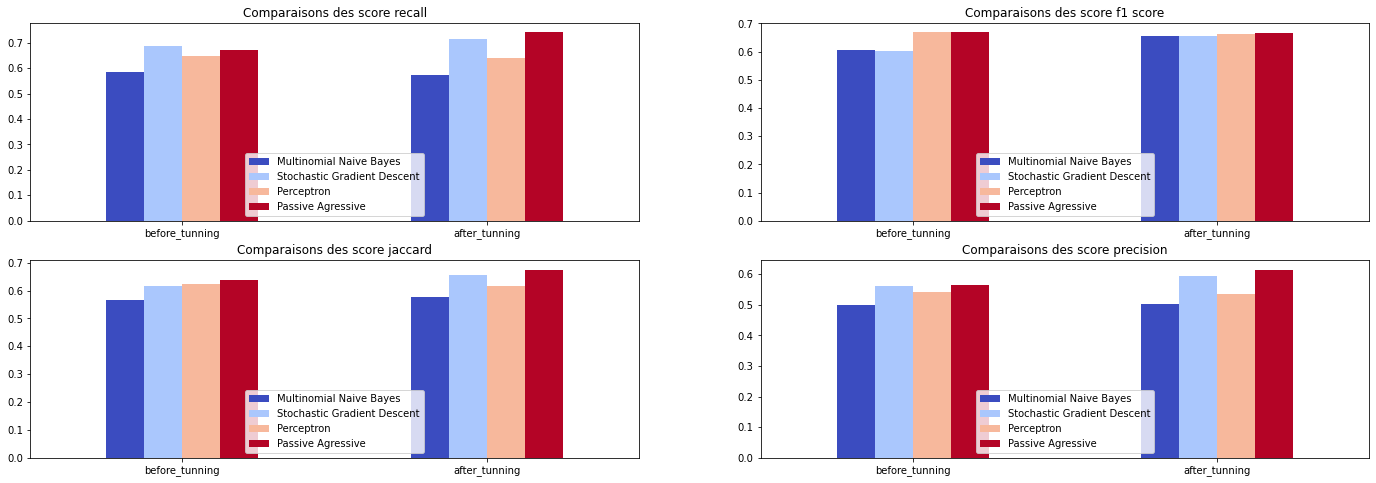

In [293]:
fig,axs=plt.subplots(2,2,)
j=0
for i in scores.keys():
    #plt.figure(figsize=(25,8))
    axs[j//2,j%2]=scores[i].plot(kind='bar',figsize=(24,8),rot=0,colormap='coolwarm',ax=axs[j//2,j%2])
    plt.title('Comparaisons des score %s'%i)
    fig.add_subplot(axs[j//2,j%2])
    j+=1
plt.savefig('score_comparison_chart.png',bbox_inches='tight')    
plt.show()
plt.close()

In [168]:
hamm=pd.DataFrame([nb_hamm_loss,sgd_hamm_loss,pc_hamm_loss,pa_hamm_loss],index=['Naive Bayes','SGD','Perceptron','Passive Agressive'])

<Figure size 1440x1440 with 0 Axes>

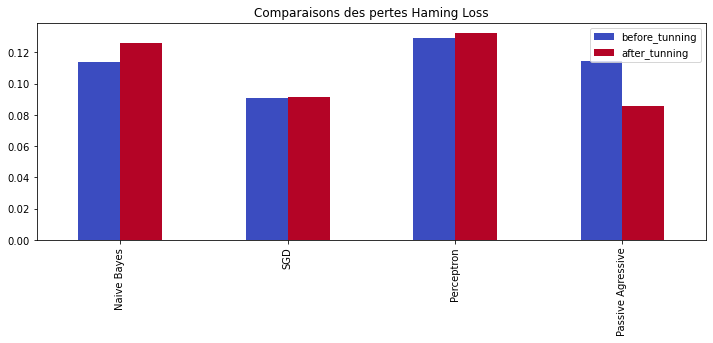

In [308]:
fig=plt.figure(figsize=(20,20))
plt.subplot(hamm.plot(kind='bar',figsize=(12,4),colormap='coolwarm',))
plt.title('Comparaisons des pertes Haming Loss')
plt.savefig('hamming_loss_comparison_chart.png',bbox_inches='tight')    
plt.show()

On voit que le PassiveAgressive performe mieux sur toutes les métriques. Nous allons comparer les temps de prédiction pour choisir le modèle.

In [155]:
startTime=time.time()
sgd.predict(prepared_test_df)
print('SGDClassifier: Temps de prédiction:',time.time()-startTime,'s')
startTime=time.time()
pa.predict(prepared_test_df)
print('PassiveAgressive:Temps de prédiction:',time.time()-startTime,'s')

SGDClassifier: Temps de prédiction: 0.3790922164916992 s
PassiveAgressive:Temps de prédiction: 0.34198880195617676 s


Le PassiveAgressive est légérement plus rapide que le SGDClassifier, regardons la moyenne sur 200 executions.

In [156]:
sgd_time=[]
pa_time=[]
for i in np.arange(200):
    startTime=time.time()
    sgd.predict(prepared_test_df)
    sgd_time.append(time.time()-startTime)
    startTime=time.time()
    pa.predict(prepared_test_df)
    pa_time.append(time.time()-startTime)


le temps moyen sur 200 predictions du SGDClassifier est :0.397109147310257
le temps moyen sur 200 predictions du PassiveAgressive est :0.36069146752357484


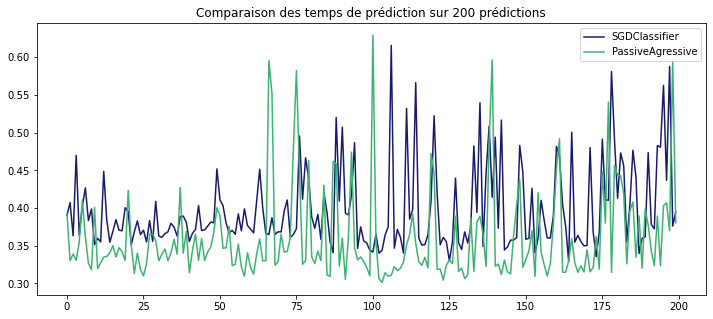

In [157]:
print('le temps moyen sur %s predictions du SGDClassifier est :%s'%(len(sgd_time),np.mean(sgd_time)))
print('le temps moyen sur %s predictions du PassiveAgressive est :%s'%(len(sgd_time),np.mean(pa_time)))
plt.figure(figsize=(12,5))
sns.lineplot(x=np.arange(len(sgd_time)),y=sgd_time,color='midnightblue')
sns.lineplot(x=np.arange(len(pa_time)),y=pa_time,color='mediumseagreen')
plt.legend(['SGDClassifier','PassiveAgressive'])
plt.title('Comparaison des temps de prédiction sur %s prédictions' %len(sgd_time))
plt.savefig('prediction_time_comparison.png',bbox_inches='tight')
plt.show()

On voit que le PassiveAgressive est le plus rapide et que les temps d'executions sont très comparables. Regardons les score obtenu plus en détail avec le classification_report.

<Figure size 1440x1440 with 0 Axes>

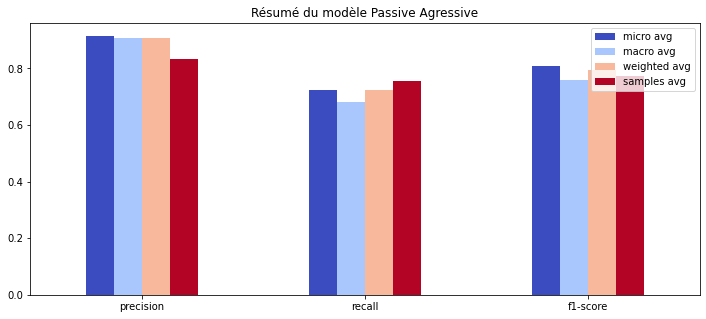

In [313]:
fig=plt.figure(figsize=(20,20))
plt.subplot(pd.DataFrame.from_dict( classification_report(y_test,pa.predict(prepared_test_df),target_names=list(mullab_enc.classes_),output_dict=True)).iloc[:-1,-4:].plot(
    kind='bar',rot=0,colormap='coolwarm',figsize=(12,5))
           )
plt.title('Résumé du modèle Passive Agressive')
plt.savefig('PassiveAgressiveScoreSummary.png',bbox_inches='tight')

plt.show()

#### export du modèle final

On entraine maintenant les préprocesseur et le modèle final sur l'ensemble des données puis on les exporte avec joblib.

In [162]:
X=col_proc.fit_transform(query_df[non_word_column+words_columns])
y=query_df[[i for i in train.columns if 'Tag_l' in i]]
y=mullab_enc.fit_transform([set([j for j in i if j is not np.nan]) for i in y.values[:]])
pa.fit(X,y)
dump(col_proc,'processing.joblib')
dump(mullab_enc,'mullabel.joblib')
dump(pa,'passiveagressive.joblib')

['passiveagressive.joblib']